In [1]:
import git
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

pd.set_option('display.max_rows', 1000)

from datetime import datetime
import sys
sys.path.append("../")
from utils import createXYPlot

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import mean_squared_error, mean_absolute_error

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Get data

In [2]:
path = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(path)

### Funzioni

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
    
# tick on mondays every week
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

    
def createBarPlot(dfplot,y,x="giorno",
                  yerr=None, 
                  title_suffix="", 
                  logscale=False, figwidth=10):

    fig, ax = plt.subplots(figsize=(figwidth,6))

    plt.bar(dfplot[x], dfplot[y],yerr=yerr)
    plt.grid()
    plt.title(f"{y} {title_suffix}",fontsize=16)
    plt.xticks(fontsize=14,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right"
              )
    plt.yticks(fontsize=14)
    if logscale: plt.yscale("log")
    plt.show()
    plt.close()
    
    
def multiple_plot(df, yname, brkdwn, xname = "giorno", lista_nomi = ["Lombardia","Piemonte"], title_suffix = "",
                  limit_x=None, limit_y=None):
    
    fig, ax = plt.subplots(figsize=(12,8))

    years = mdates.YearLocator()    # every year
    months = mdates.MonthLocator()  # every month
    weekdays = mdates.WeekdayLocator(byweekday=MO)
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter('%Y-%m-%d')


    # format the ticks
    ax.xaxis.set_major_locator(weekdays)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(days)

    for nome in lista_nomi:
        dfp = df[df[brkdwn]==nome]
        plt.plot(dfp[xname],dfp[yname],"-o",label=nome)

    #print(dfp.reset_index()[0])
    #plt.plot(dfp['giorno'],dfp["expected"],"-o")
    
    plt.grid(which="both")
    fig.autofmt_xdate()
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    plt.xticks(fontsize=14)
    if limit_x: plt.xlim(limit_x[0],limit_x[1])
    if limit_y: plt.ylim(limit_y[0],limit_y[1])
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12)
    plt.title(f"{yname} per {brkdwn} {title_suffix}", fontsize=18)

    plt.show()
    plt.close()
    

    
    
def get_provinces_by_regio(regione):
    return [ x for x in list(df_prov[df_prov["denominazione_regione"]==regione]["denominazione_provincia"].unique()) if "aggiornamento" not in x ]



def getVariables(df):

    df["data"] = pd.to_datetime(df["data"])
    df["dow"] = df["data"].dt.dayofweek
    df = df.fillna({"tamponi_test_antigenico_rapido":0})
    
    df["tamponi_test_molecolare"] = df["tamponi_test_molecolare"].combine_first(df["tamponi"])
    
    df["nuovi_positivi_lag_7"] = df["nuovi_positivi"].shift(7)
    df["ingressi_terapia_intensiva_lag_7"] = df["ingressi_terapia_intensiva"].shift(7)

    df['giorno'] = df['data'].dt.date
    
    df["nuovi_positivi_test_molecolare"] = df["totale_positivi_test_molecolare"] - df["totale_positivi_test_molecolare"].shift(1)
    df["nuovi_positivi_test_rapido"] = df["totale_positivi_test_antigenico_rapido"] - df["totale_positivi_test_antigenico_rapido"].shift(1)
    
    df["variazione_deceduti"] = df["deceduti"] - df["deceduti"].shift(1)
    df["variazione_positivi"] = df["totale_positivi"] - df["totale_positivi"].shift(1)
    df["variazione_relativa_positivi"] = df["nuovi_positivi"]/df["totale_positivi"].shift(1)
    df["variazione_deceduti_media_7"] = df.sort_values("data")["variazione_deceduti"].rolling(7).mean()
    df["variazione_guariti"] = df["dimessi_guariti"] - df["dimessi_guariti"].shift(1)
    df["variazione_ospedalizzati"] = df["totale_ospedalizzati"] - df["totale_ospedalizzati"].shift(1)
    df["variazione_ricoverati_con_sintomi"] = df["ricoverati_con_sintomi"] - df["ricoverati_con_sintomi"].shift(1)
    df["variazione_isolamento_domiciliare"] = df["isolamento_domiciliare"] - df["isolamento_domiciliare"].shift(1)
    df["variazione_terapia_intensiva"] = df["terapia_intensiva"] - df["terapia_intensiva"].shift(1)
    df["variazione_tamponi"] = df["tamponi"] - df["tamponi"].shift(1)
    df["variazione_tamponi_molecolari"] = df["tamponi_test_molecolare"] - df["tamponi_test_molecolare"].shift(1)
    df["variazione_tamponi_rapidi"] = df["tamponi_test_antigenico_rapido"] - df["tamponi_test_antigenico_rapido"].shift(1)
    
    df["ti_ratio"] = 100 * df["ingressi_terapia_intensiva"]/df["nuovi_positivi_lag_7"]
    df["death_ti_ratio"] = 100 * df["variazione_deceduti"]/df["ingressi_terapia_intensiva_lag_7"]
    
    df["tasso_positivi"] = 100*(df["nuovi_positivi"]/df["variazione_tamponi"])
    df["tasso_positivi_test_rapido"] = 100*(df["nuovi_positivi_test_rapido"]/df["variazione_tamponi_rapidi"])
    df["tasso_positivi_test_molecolare"] = 100*(df["nuovi_positivi_test_molecolare"]/df["variazione_tamponi_molecolari"])
    df["tasso_positivi_test_molecolare"] =  df["tasso_positivi_test_molecolare"].combine_first(df["tasso_positivi"])

    df["mortalità"] = df["deceduti"]/df["totale_casi"]
    df["variazione_mortalità"] = df["mortalità"]-df["mortalità"].shift(1)
    df["sd_mortalità"] = np.sqrt((df["mortalità"]*(1-df["mortalità"]))/df["totale_casi"])
    df["sd_tasso_positivi"] = np.sqrt((df["tasso_positivi"]*(1-df["tasso_positivi"]))/df["variazione_tamponi"])
    
    
    df["frazione_ospedalizzati"] = df["totale_ospedalizzati"]/df["totale_positivi"]
    df["frazione_terapia_intensiva"] = df["terapia_intensiva"]/df["totale_positivi"]
    df["frazione_isolamento_domiciliare"] = df["isolamento_domiciliare"]/df["totale_positivi"]
    df["frazione_tamponi_rapidi"] = df["variazione_tamponi_rapidi"]/df["variazione_tamponi"]
    
    
        
    roll_mean_vars = ["nuovi_positivi",
                      "ti_ratio",
                      "variazione_tamponi",
                      "variazione_positivi",
                      "variazione_terapia_intensiva",
                      "variazione_relativa_positivi",
                      "tasso_positivi",
                      "tasso_positivi_test_rapido",
                      "tasso_positivi_test_molecolare",
                      "ingressi_terapia_intensiva",
                      "variazione_ospedalizzati",
                      "variazione_guariti",
                      "frazione_ospedalizzati",
                      "frazione_terapia_intensiva",
                      "frazione_isolamento_domiciliare",
                      "mortalità",
                      "frazione_tamponi_rapidi",
                      "variazione_tamponi_rapidi",
                      "variazione_tamponi_molecolari"
                     ]
    
    for var in roll_mean_vars:
        df[var+"_media_7"] = df.sort_values("data")[var].rolling(7).mean()

    df = df.sort_values(by="giorno",ascending = False).reset_index().drop(columns=["index"])
    
    return df


def plot_summary(dfplot, suffix):
    fig, ax = plt.subplots(figsize=(16,8),dpi=300)

    years = mdates.YearLocator()    # every year
    months = mdates.MonthLocator()  # every month
    weekdays = mdates.WeekdayLocator(byweekday=MO)
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter('%Y-%m-%d')

    WIDTH=0.35
    DAY_INTERVAL = 14

    df_bar = dfplot.sort_values(by="data",ascending=True).reset_index()
    
    #print(df_bar.head())
    
    indexes = np.arange(0,len(df_bar.index),DAY_INTERVAL)
    labels = [ str(df_bar["giorno"].tolist()[i]) for i in indexes]

    #print(labels)

    plt.bar(df_bar.index,df_bar["nuovi_positivi"],label="contagiati",alpha=0.5,width=WIDTH,color="red",align="center")
    plt.bar(df_bar.index-WIDTH,df_bar["variazione_deceduti"],label="deceduti",alpha=0.6,width=WIDTH,color="black",align="center")
    plt.bar(df_bar.index+WIDTH,df_bar["variazione_guariti"],label="guariti",alpha=0.6,width=WIDTH,color="green",align="center")
    plt.plot(df_bar.index,df_bar["nuovi_positivi_media_7"],label="contagiati (media mobile)", linewidth=3,color="darkred")

    plt.xticks(indexes,
               labels = labels, 
               fontsize=15, 
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right",
              )
    plt.grid()
    plt.title(f"Aggiornamento {suffix}",fontsize=20)
    plt.legend(fontsize=14,loc="upper left")
    plt.yticks(fontsize=15)
    plt.savefig(f"./plots/{oggi}/aggiornamento_{suffix}.png",bbox_inches="tight")
    del(fig)

In [4]:
def define_rnn_data(df, feas, test_window_days=7, lags=[]):
    df["dow"] = df["data"].dt.dayofweek

    df_rnn = df.sort_values(by="data").set_index("data")[feas]
    for f in feas:
        for s in lags:
            df_rnn[f"{f}_lag_{s}"] = df_rnn[f].shift(s)

    df_rnn = df_rnn.dropna()

    test = df_rnn[-test_window_days:]
    train = df_rnn[:-test_window_days]
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    
    return df_rnn, test, train, scaler, scaled_train, scaled_test

### Valori nazionali

In [5]:
df = getVariables(df)
oggi = df["giorno"][0]
print(oggi)

import subprocess
plots_folder = f"./plots/{oggi}"
print(plots_folder)
res = subprocess.run(f"mkdir -p {plots_folder}",shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

2022-01-08
./plots/2022-01-08


/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


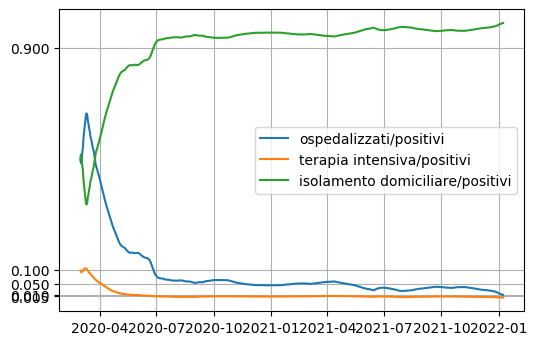

In [6]:
plt.figure(dpi=100)
plt.plot(df["giorno"],df["frazione_ospedalizzati_media_7"],label="ospedalizzati/positivi")
plt.plot(df["giorno"],df["frazione_terapia_intensiva_media_7"],label="terapia intensiva/positivi")
plt.plot(df["giorno"],df["frazione_isolamento_domiciliare_media_7"],label="isolamento domiciliare/positivi")
plt.grid()
plt.legend()
_=plt.yticks([0.005,0.01,0.05,0.1,0.9])

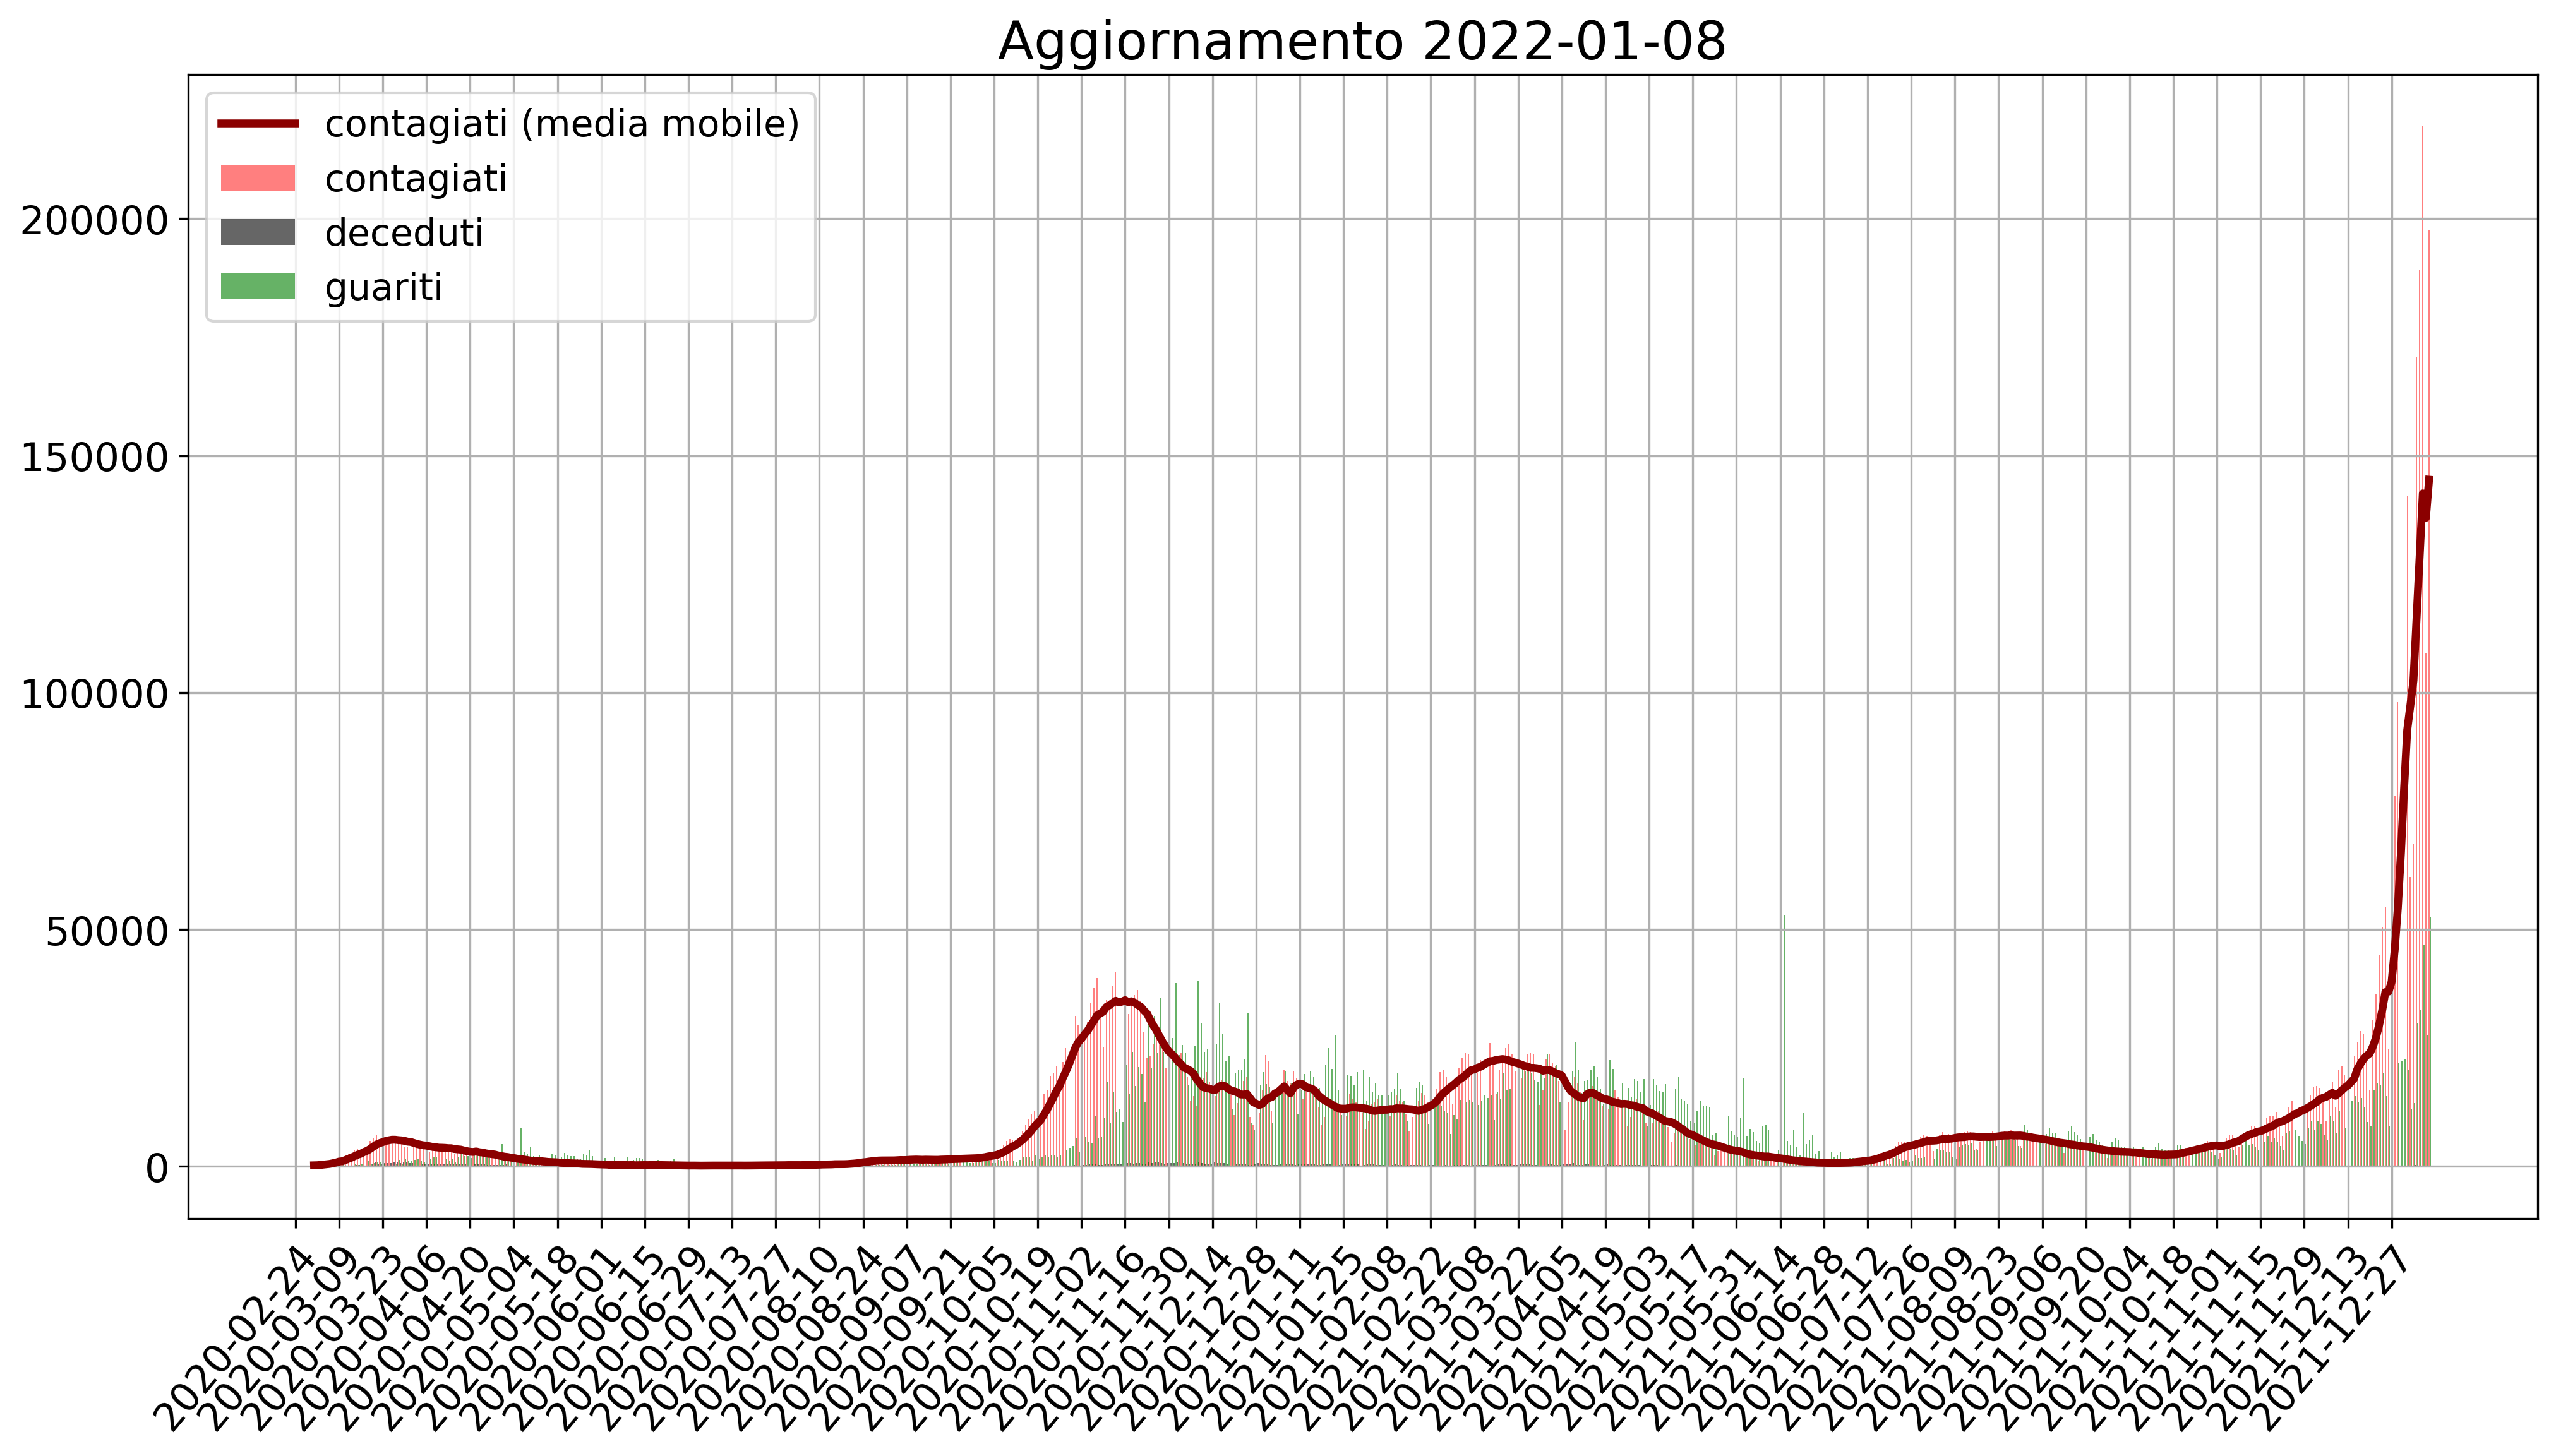

In [7]:
plot_summary(df, suffix=oggi)

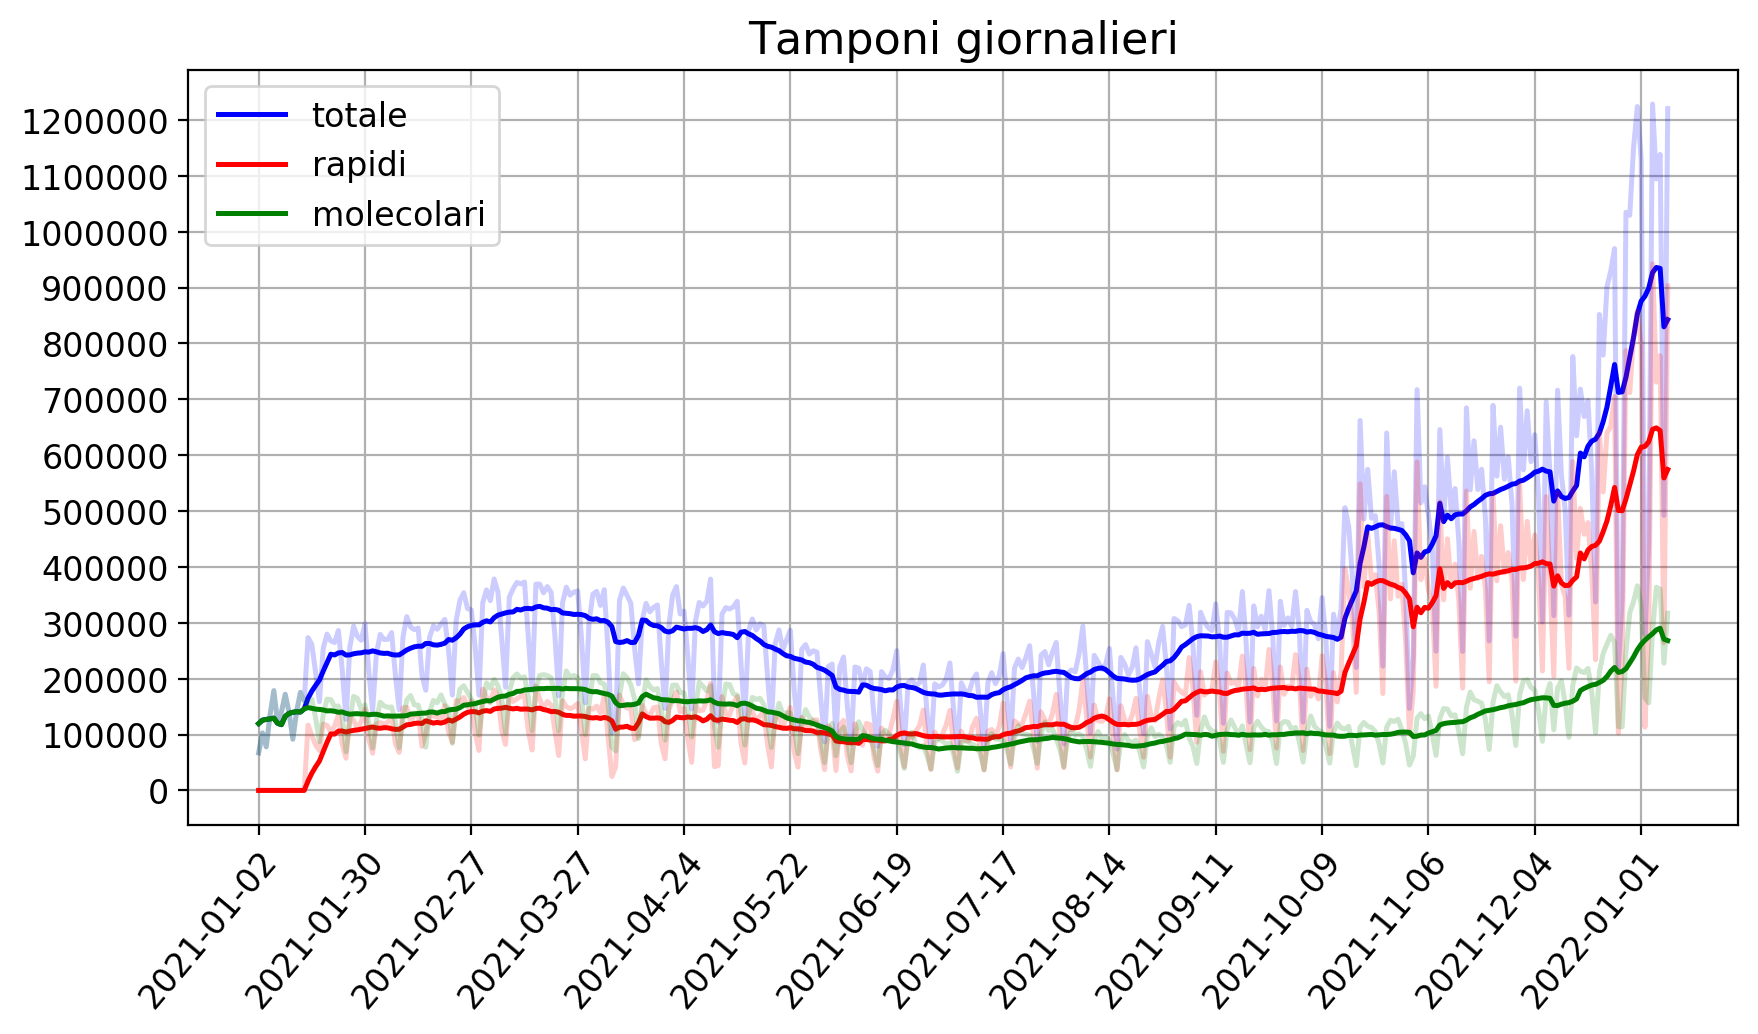

In [10]:
createXYPlot(df,
             days_interval = 28,
             bar_width=0.75,
             dpis=200,
             linewidth=1.8,
             y=["variazione_tamponi",
                "variazione_tamponi_media_7",
                "variazione_tamponi_rapidi",
                "variazione_tamponi_rapidi_media_7",
                "variazione_tamponi_molecolari",
                "variazione_tamponi_molecolari_media_7",
               ],
             alphas=[0.2,1.0,0.2,1.0,0.2,1.0],
             colors=["b","b","r","r","g","g"],
             labels=[None,
                     "totale",
                     None,
                     "rapidi",
                     None,
                     "molecolari"
                    ],
             x="giorno",
             plots_folder=plots_folder,
             savename="tamponi.png",
             figsize_x=10,
             figsize_y=5,
             start_date="2021-01-01",
             title="Tamponi giornalieri",
             yticks=np.arange(0,1.3e6,1e5))

In [ ]:
df[["giorno","variazione_tamponi_molecolari"]]

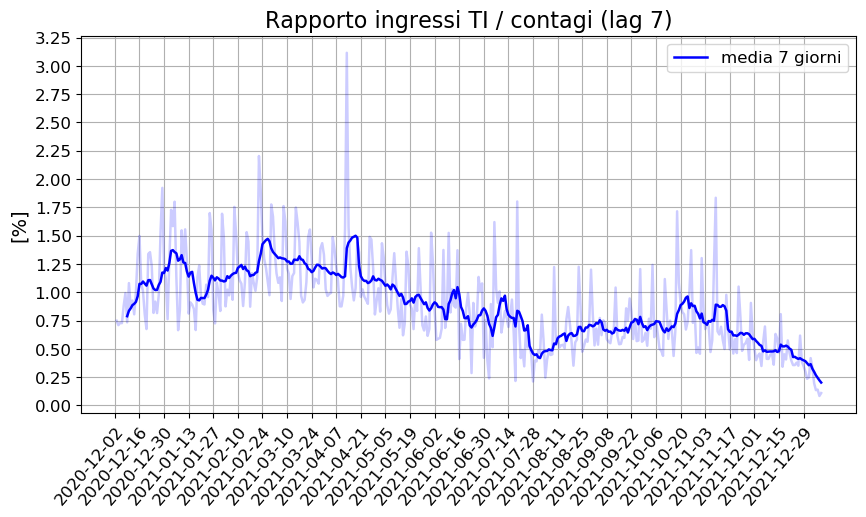

In [13]:
createXYPlot(df, x="giorno", 
             y=["ti_ratio",
                "ti_ratio_media_7"], 
             plots_folder=plots_folder,
             start_date="2020-12-01",
             days_interval=14,
             linewidth=1.8,
             colors=["b","b"],
             alphas=[0.2,1],
             figsize_x=10,
             figsize_y=5,
             labels=[None, "media 7 giorni"],
             title="Rapporto ingressi TI / contagi (lag 7)",
             savename="ti_ratio",
             yticks=np.arange(0,3.5,0.25),
             ytitle="[%]"
            )

In [14]:
df[["ingressi_terapia_intensiva_lag_7","variazione_deceduti"]]

ingressi_terapia_intensiva_lag_7  variazione_deceduti
0                               135.0                184.0
1                               119.0                223.0
2                               134.0                198.0
3                               126.0                231.0
4                               119.0                259.0
5                               100.0                140.0
6                                85.0                133.0
7                               106.0                111.0
8                               102.0                155.0
9                                93.0                156.0
10                               92.0                148.0
11                               96.0                190.0
12                               73.0                142.0
13                               78.0                 81.0
14                               95.0                144.0
15                               70.0                141.0
16                              101.0                168.0
17                               84.0                146.0
18                               93.0                153.0
19                               60.0                137.0
20                               54.0                 97.0
21                               76.0                123.0
22                               76.0                120.0
23                               69.0                123.0
24                               62.0                129.0
25                               89.0                120.0
26                               45.0                 98.0
27                               45.0                 66.0
28                               59.0                 96.0
29                               60.0                118.0
30                               55.0                 79.0
31                               62.0                 86.0
32                               64.0                 99.0
33                               58.0                 92.0
34                               39.0                 43.0
35                               68.0                 75.0
36                               58.0                 74.0
37                               57.0                 72.0
38                               49.0                103.0
39                               61.0                 89.0
40                               54.0                 65.0
41                               35.0                 47.0
42                               50.0                 90.0
43                               39.0                 51.0
44                               55.0                 71.0
45                               39.0                 85.0
46                               41.0                 83.0
47                               41.0                 70.0
48                               29.0                 46.0
49                               39.0                 49.0
50                               47.0                 48.0
51                               37.0                 69.0
52                               34.0                 72.0
53                               52.0                 74.0
54                               35.0                 44.0
55                               26.0                 36.0
56                               23.0                 53.0
57                               37.0                 68.0
58                               36.0                 67.0
59                               31.0                 60.0
60                               34.0                 68.0
61                               33.0                 38.0
62                               17.0                 20.0
63                               20.0                 31.0
64                               18.0                 51.0
65                               32.0                 59.0
66                               27.0               

In [15]:
df.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido', 'dow', 'nuovi_positivi_lag_7',
       'ingressi_terapia_intensiva_lag_7', 'giorno',
       'nuovi_positivi_test_molecolare', 'nuovi_positivi_test_rapido',
       'variazione_deceduti', 'variazione_positivi',
       'variazione_relativa_positivi', 'variazione_deceduti_media_7',
       'variazione_guariti', 'variazione_ospedalizzati',
       'variazione_ricoverati_con_sintomi',
       'variazione_isolamento_domiciliare', 'vari

In [16]:
df.sort_values(by="tasso_positivi_test_rapido",ascending=False)[["giorno","tasso_positivi_test_rapido"]].head(10)

giorno  tasso_positivi_test_rapido
1  2022-01-07                   16.052511
2  2022-01-06                   15.824271
3  2022-01-05                   13.296358
0  2022-01-08                   12.616702
6  2022-01-02                   11.573018
4  2022-01-04                   10.957686
5  2022-01-03                    8.148205
7  2022-01-01                    7.774561
8  2021-12-31                    7.514970
9  2021-12-30                    6.182755

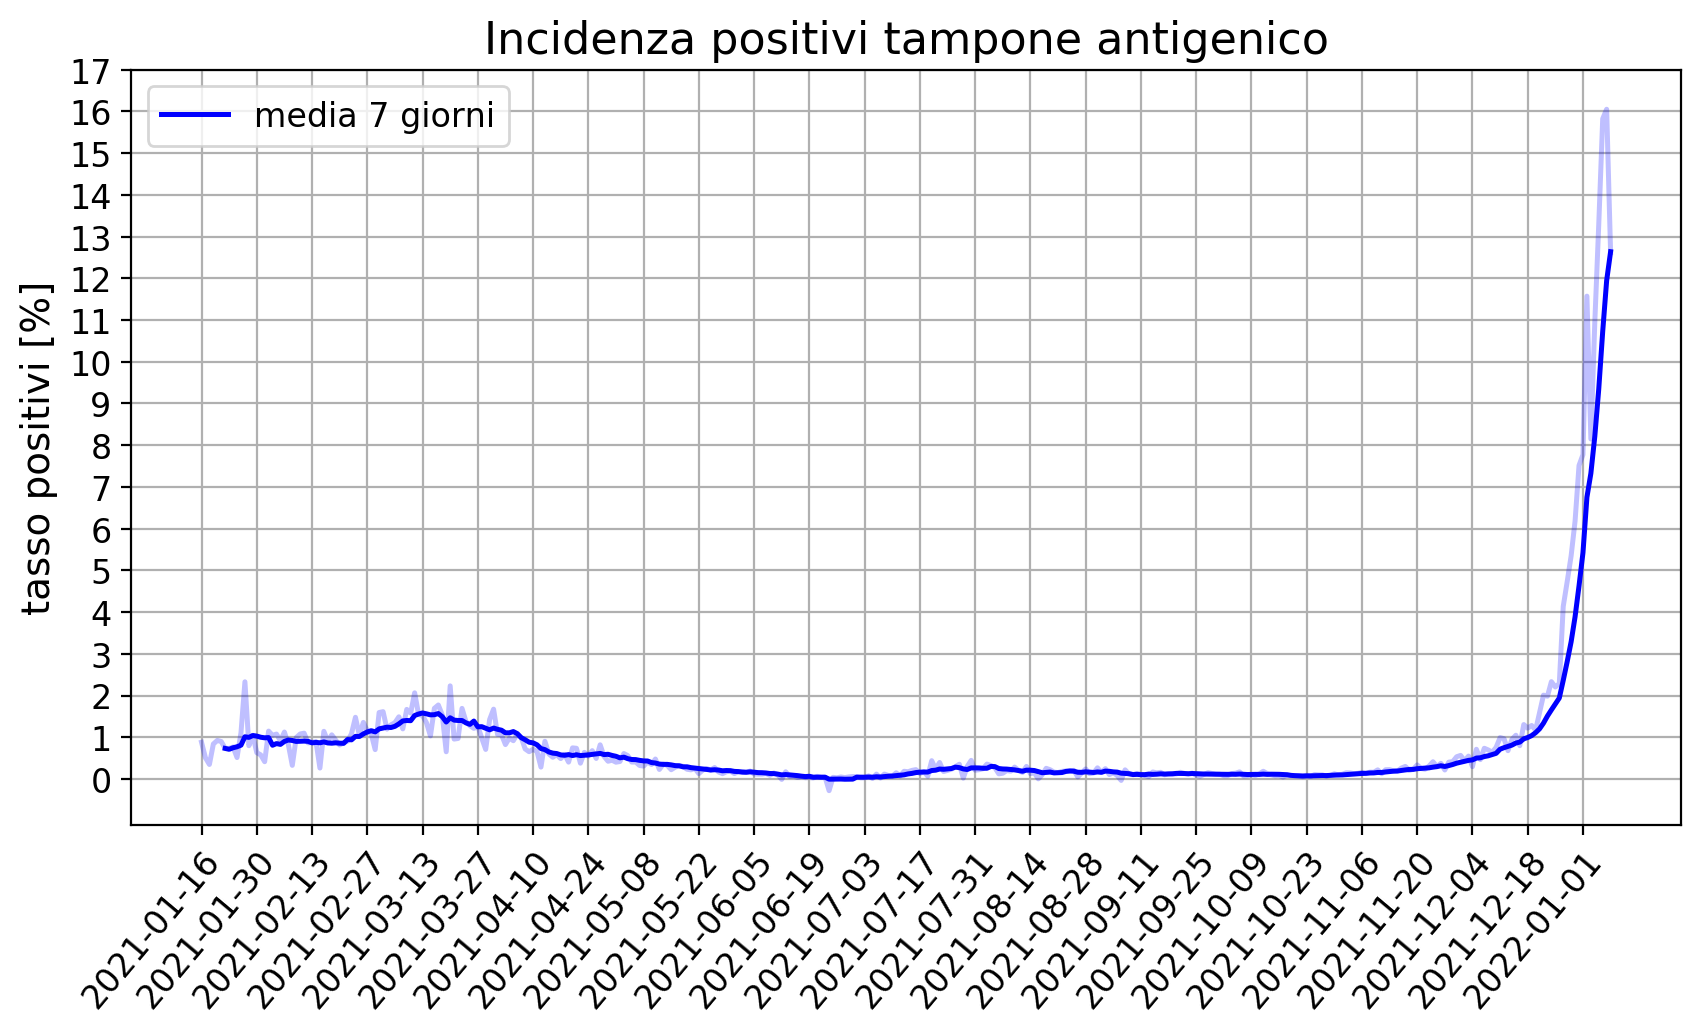

In [18]:
createXYPlot(df,
             days_interval = 14,
             x="giorno",
             linewidth=1.8,
             dpis=200,
             ytitle="tasso positivi [%]",
             y=[
                "tasso_positivi_test_rapido",
                "tasso_positivi_test_rapido_media_7", 
               ],
             labels=[None,"media 7 giorni"],
             alphas=[0.25,1],
             colors=["b","b"],
             plots_folder=plots_folder,
             title="Incidenza positivi tampone antigenico",
             start_date="2021-01-15",
             figsize_x=10,
             figsize_y=5,
             yticks=np.arange(0.00, 18.0, 1.0),
             savename="tasso_positivi_tampone_rapido.png")

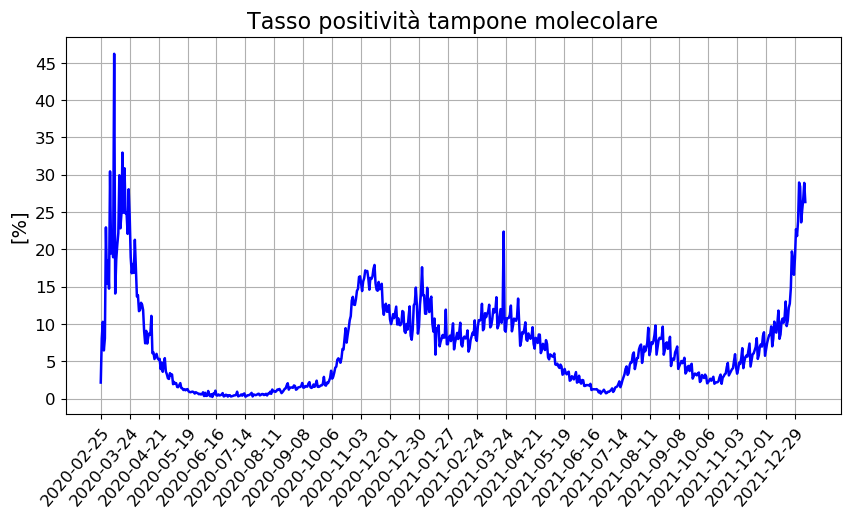

In [20]:
createXYPlot(df,y=["tasso_positivi_test_molecolare"],
             x="giorno",
             days_interval=28,
             start_date="2020-01-01",
             plots_folder=plots_folder,
             remove_negative=True,
             colors=["b"],
             linewidth=1.8,
             yticks=np.arange(0,50,5),
             title="Tasso positività tampone molecolare",
             ytitle="[%]",
             figsize_x=10,
             figsize_y=5,
             savename="tasso_positivi_tampone_molecolare.png",
            )

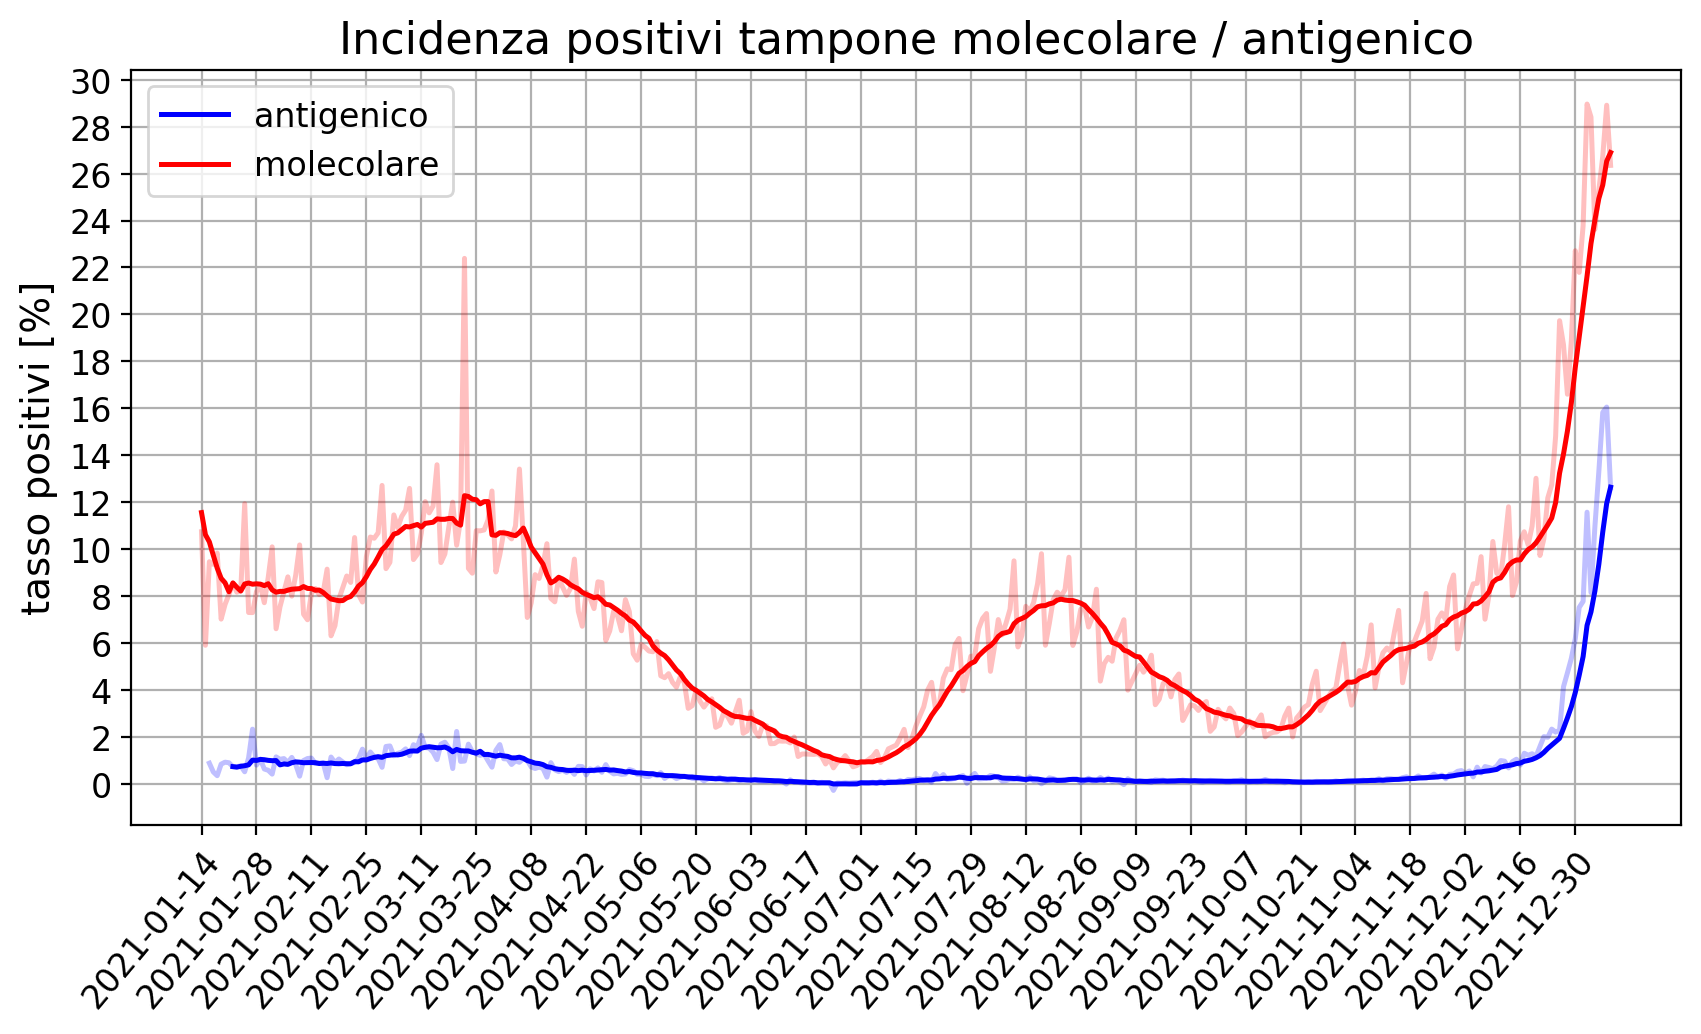

In [22]:
createXYPlot(df,
             days_interval = 14,
             x="giorno",
             linewidth=1.8,
             dpis=200,
             ytitle="tasso positivi [%]",
             y=[
                "tasso_positivi_test_rapido",
                "tasso_positivi_test_rapido_media_7",
                "tasso_positivi_test_molecolare",
                "tasso_positivi_test_molecolare_media_7",
               ],
             colors=["b","b","r","r"],
             alphas=[0.25,1,0.25,1],
             labels=[None,"antigenico",None,"molecolare"],
             plots_folder=plots_folder,
             title="Incidenza positivi tampone molecolare / antigenico",
             start_date="2021-01-13",
             figsize_x=10,
             figsize_y=5,
             yticks=np.arange(0,32,2),
             savename="tasso_positivi.png")

In [23]:
df.sort_values(by=["tasso_positivi_test_molecolare"], ascending=False)[["data","tasso_positivi_test_molecolare","variazione_tamponi_molecolari"]]

data  tasso_positivi_test_molecolare  \
670 2020-03-09 18:00:00                       46.207251   
662 2020-03-17 17:00:00                       32.968677   
660 2020-03-19 17:00:00                       30.877234   
674 2020-03-05 18:00:00                       30.455446   
665 2020-03-14 17:00:00                       29.934943   
6   2022-01-02 17:00:00                       28.962627   
1   2022-01-07 17:00:00                       28.912373   
5   2022-01-03 17:00:00                       28.409693   
656 2020-03-23 17:00:00                       28.061643   
2   2022-01-06 17:00:00                       26.732932   
0   2022-01-08 17:00:00                       26.349392   
3   2022-01-05 17:00:00                       25.282736   
661 2020-03-18 17:00:00                       24.917081   
658 2020-03-21 17:00:00                       24.897479   
659 2020-03-20 17:00:00                       24.828902   
663 2020-03-16 17:00:00                       24.749292   
655 2020-03-24 17:00:00                       24.418496   
7   2022-01-01 17:00:00                       23.785820   
4   2022-01-04 17:00:00                       23.622744   
678 2020-03-01 18:00:00                       22.952149   
664 2020-03-15 17:00:00                       22.824083   
9   2021-12-30 17:00:00                       22.712911   
292 2021-03-22 17:00:00                       22.387011   
666 2020-03-13 17:00:00                       22.192211   
657 2020-03-22 17:00:00                       22.081017   
672 2020-03-07 18:00:00                       21.865685   
8   2021-12-31 17:00:00                       21.789963   
650 2020-03-29 17:00:00                       21.290402   
667 2020-03-12 17:00:00                       20.619118   
13  2021-12-26 17:00:00                       19.733051   
673 2020-03-06 18:00:00                       19.464598   
654 2020-03-25 17:00:00                       18.958553   
671 2020-03-08 18:00:00                       18.946032   
10  2021-12-29 17:00:00                       18.878804   
12  2021-12-27 17:00:00                       18.705276   
668 2020-03-11 17:00:00                       18.663762   
676 2020-03-03 18:00:00                       18.558343   
652 2020-03-27 17:00:00                       18.047185   
418 2020-11-16 17:00:00                       17.917898   
371 2021-01-02 17:00:00                       17.612469   
419 2020-11-15 17:00:00                       17.400589   
649 2020-03-30 17:00:00                       17.360367   
427 2020-11-07 17:00:00                       17.184135   
425 2020-11-09 17:00:00                       17.106786   
426 2020-11-08 17:00:00                       17.063575   
651 2020-03-28 17:00:00                       16.853330   
653 2020-03-26 17:00:00                       16.804588   
11  2021-12-28 17:00:00                       16.597973   
432 2020-11-02 17:00:00                       16.394928   
420 2020-11-14 17:00:00                       16.361800   
433 2020-11-01 17:00:00                       16.301913   
422 2020-11-12 17:00:00                       16.183439   
428 2020-11-06 17:00:00                       16.140793   
424 2020-11-10 17:00:00                       16.117892   
421 2020-11-13 17:00:00                       16.045789   
429 2020-11-05 17:00:00                       15.692365   
414 2020-11-20 17:00:00                       15.642838   
431 2020-11-03 17:00:00                       15.494248   
417 2020-11-17 17:00:00                       15.442439   
677 2020-03-02 18:00:00                       15.419297   
411 2020-11-23 17:00:00                       15.394944   
412 2020-11-22 17:00:00                       15.013219   
377 2020-12-27 17:00:00                       14.885018   
366 2021-01-07 17:00:00                       14.858792   
14  2021-12-25 17:00:00                       14.817667   
675 2020-03-04 18:00:00                       14.745039   
434 2020-10-31 17:00:00                       14.710542   
413 202

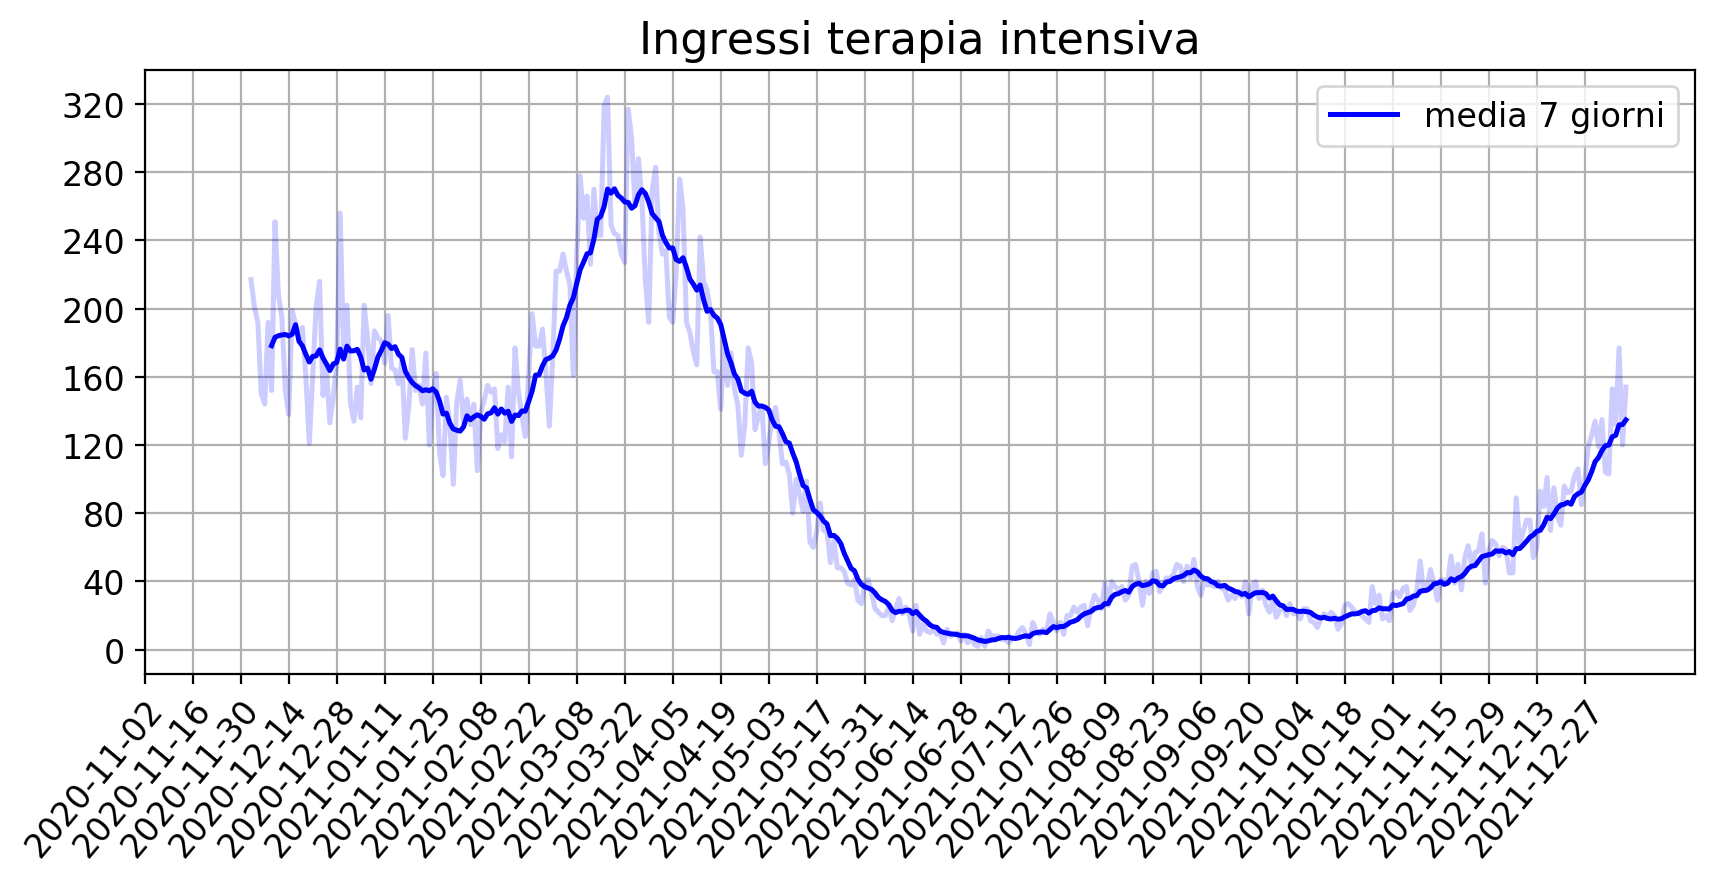

In [25]:
createXYPlot(df,
             days_interval = 14,
             x="giorno",
             linewidth=1.8,
             dpis=200,
             y=["ingressi_terapia_intensiva",
                "ingressi_terapia_intensiva_media_7"
               ],
             labels=[None,"media 7 giorni"],
             alphas=[0.2,1],
             colors=["b","b"],
             plots_folder=plots_folder,
             start_date="2020-11-01",
             yticks=np.arange(0,340,40),
             figsize_x=10,
             figsize_y=4,
             title="Ingressi terapia intensiva",
             savename="ingressi_ti")

In [ ]:
def stakHist(df, var_names, startDate):
    
    fig, ax = plt.subplots(dpi=200,figsize=(20,8))
    dfplot = df[df.giorno >= datetime.strptime(startDate,"%Y-%m-%d").date()]
    dfplot = dfplot.sort_values(by="giorno",ascending=True).reset_index()
    
    indexes = np.arange(0,len(dfplot.index),4)
    labels = [ str(dfplot["giorno"].tolist()[i]) for i in indexes]
    
    
    for name in var_names.keys():
        y = dfplot[name]
        if name == "variazione_deceduti": y = -y
        plt.bar(dfplot.index+var_names[name][0], y, color=var_names[name][1],label=name, alpha=0.6,width=0.3,align="center")
    plt.xticks(indexes,
               labels,
               fontsize=14,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right"
              )
    plt.yticks(fontsize=16)
    plt.grid()
    plt.legend(fontsize=16)
    plt.title("Variazione Terapia intensiva",fontsize=20)
    plt.savefig(f"./plots/{oggi}/ti_morti_ingressi.png",bbox_inches="tight")
        

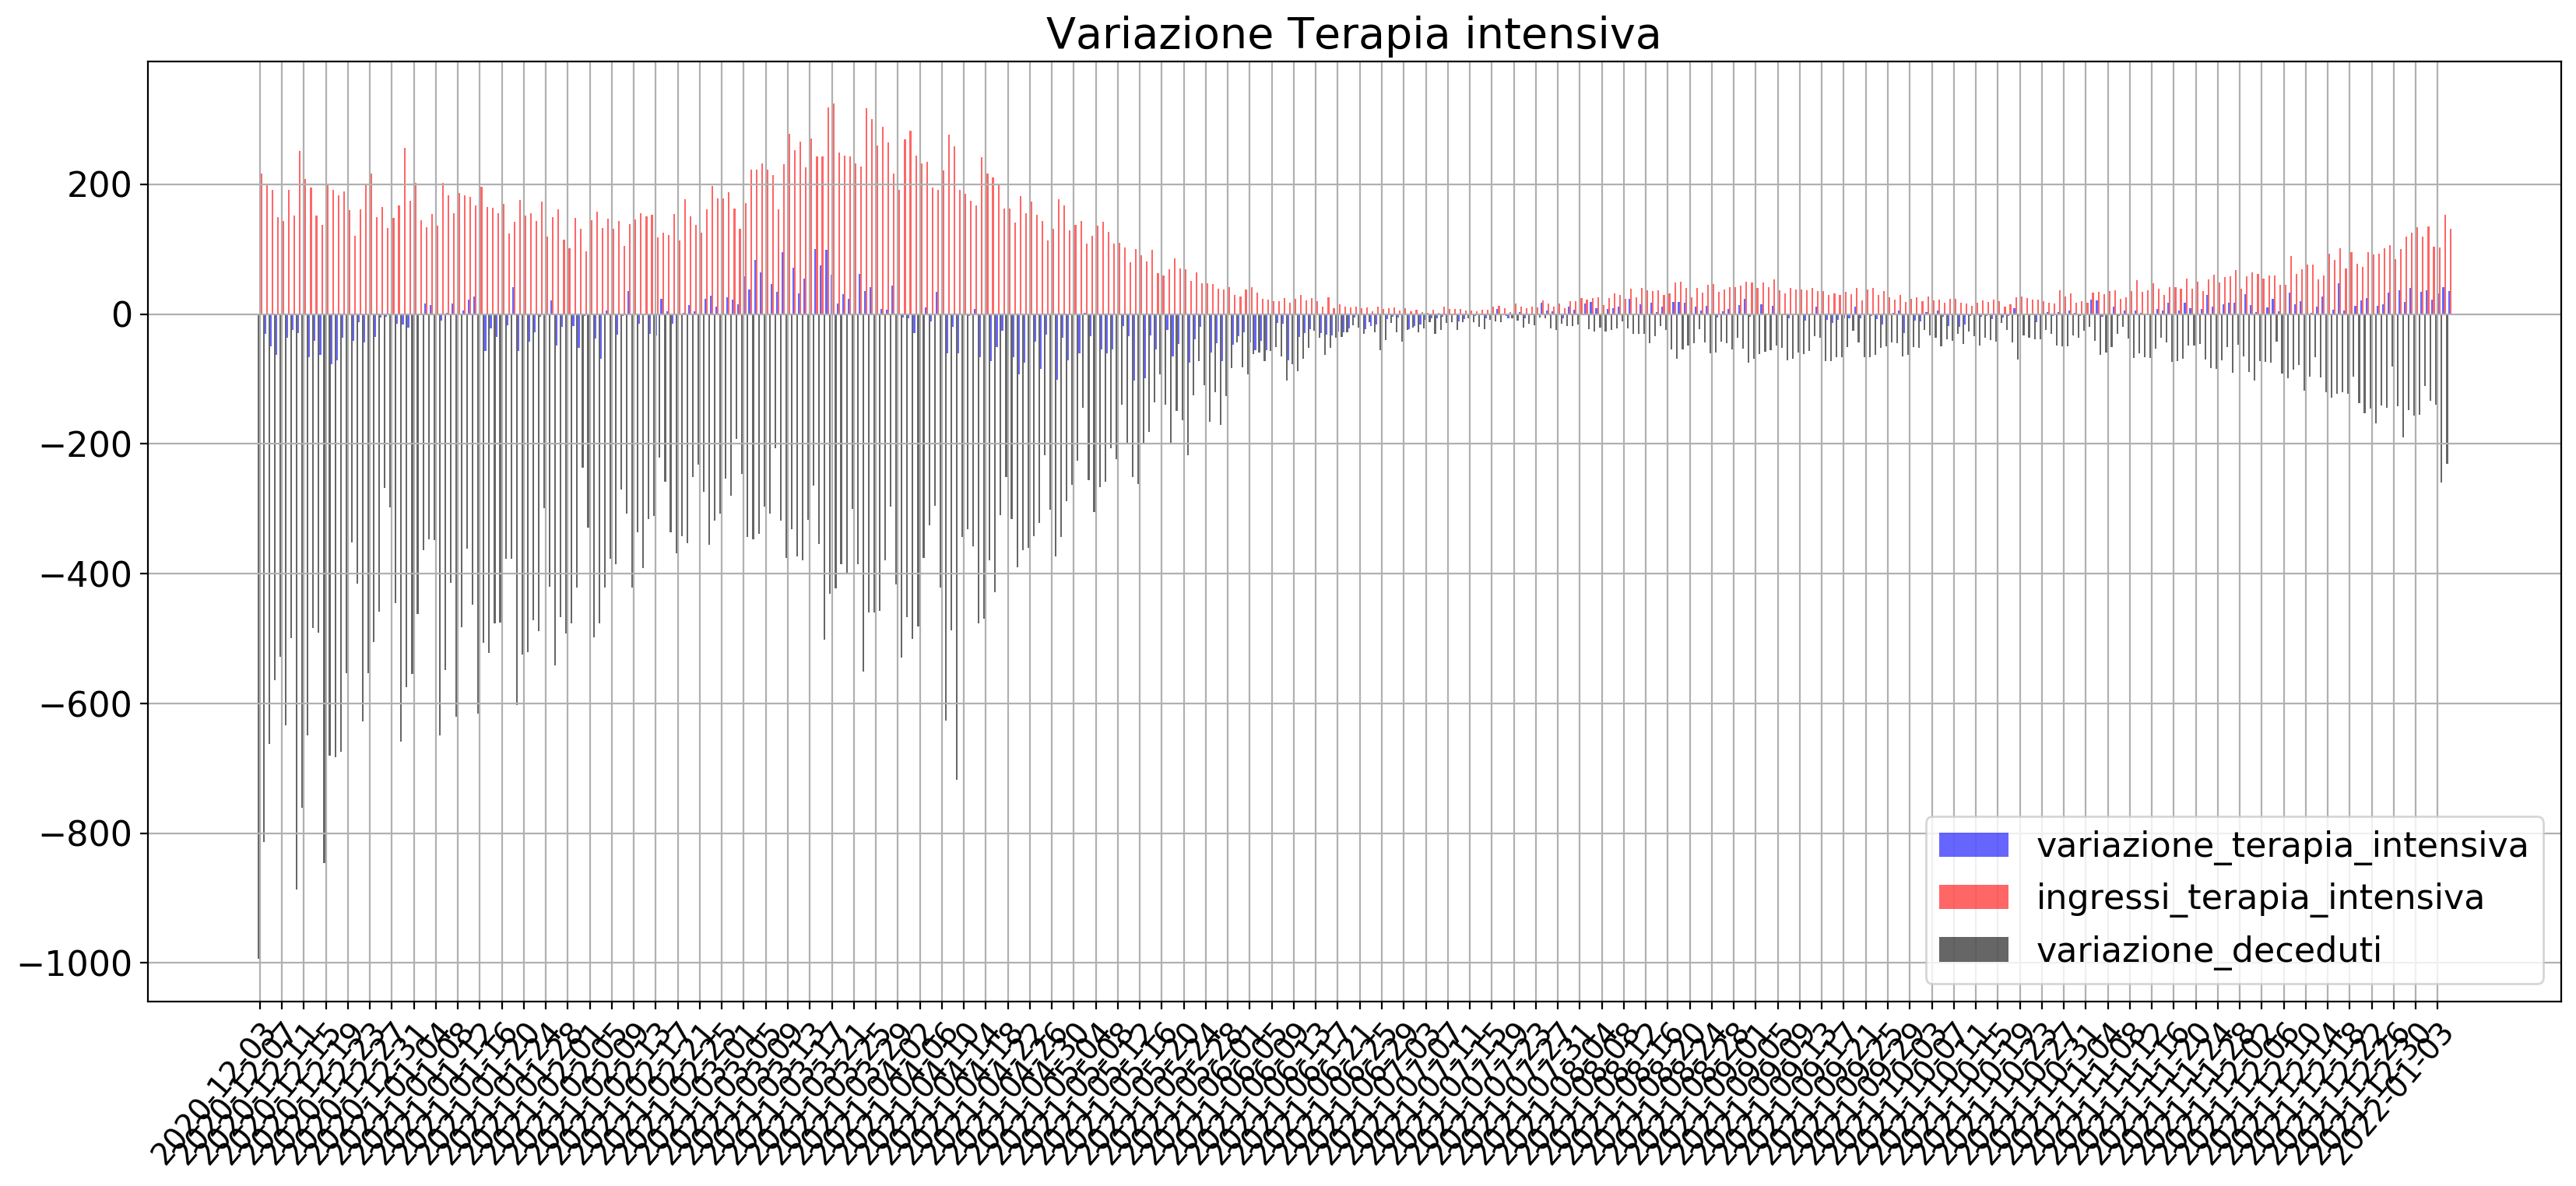

In [60]:
stakHist(df,
         {"variazione_terapia_intensiva":[0,"blue"],
          "ingressi_terapia_intensiva":[0.3,"red"],
          "variazione_deceduti":[-0.3,"black"]},
         "2020-12-03")

In [26]:
createXYPlot(df,
             y=["mortalità"],
             x="giorno",
             today=oggi,
             colors=["black","red"],
             days_interval = 28,
             dpis=500,
             plots_folder=plots_folder,
             yticks=np.arange(0.01,0.16,0.01)
            )

TypeError: createXYPlot() got an unexpected keyword argument 'today'

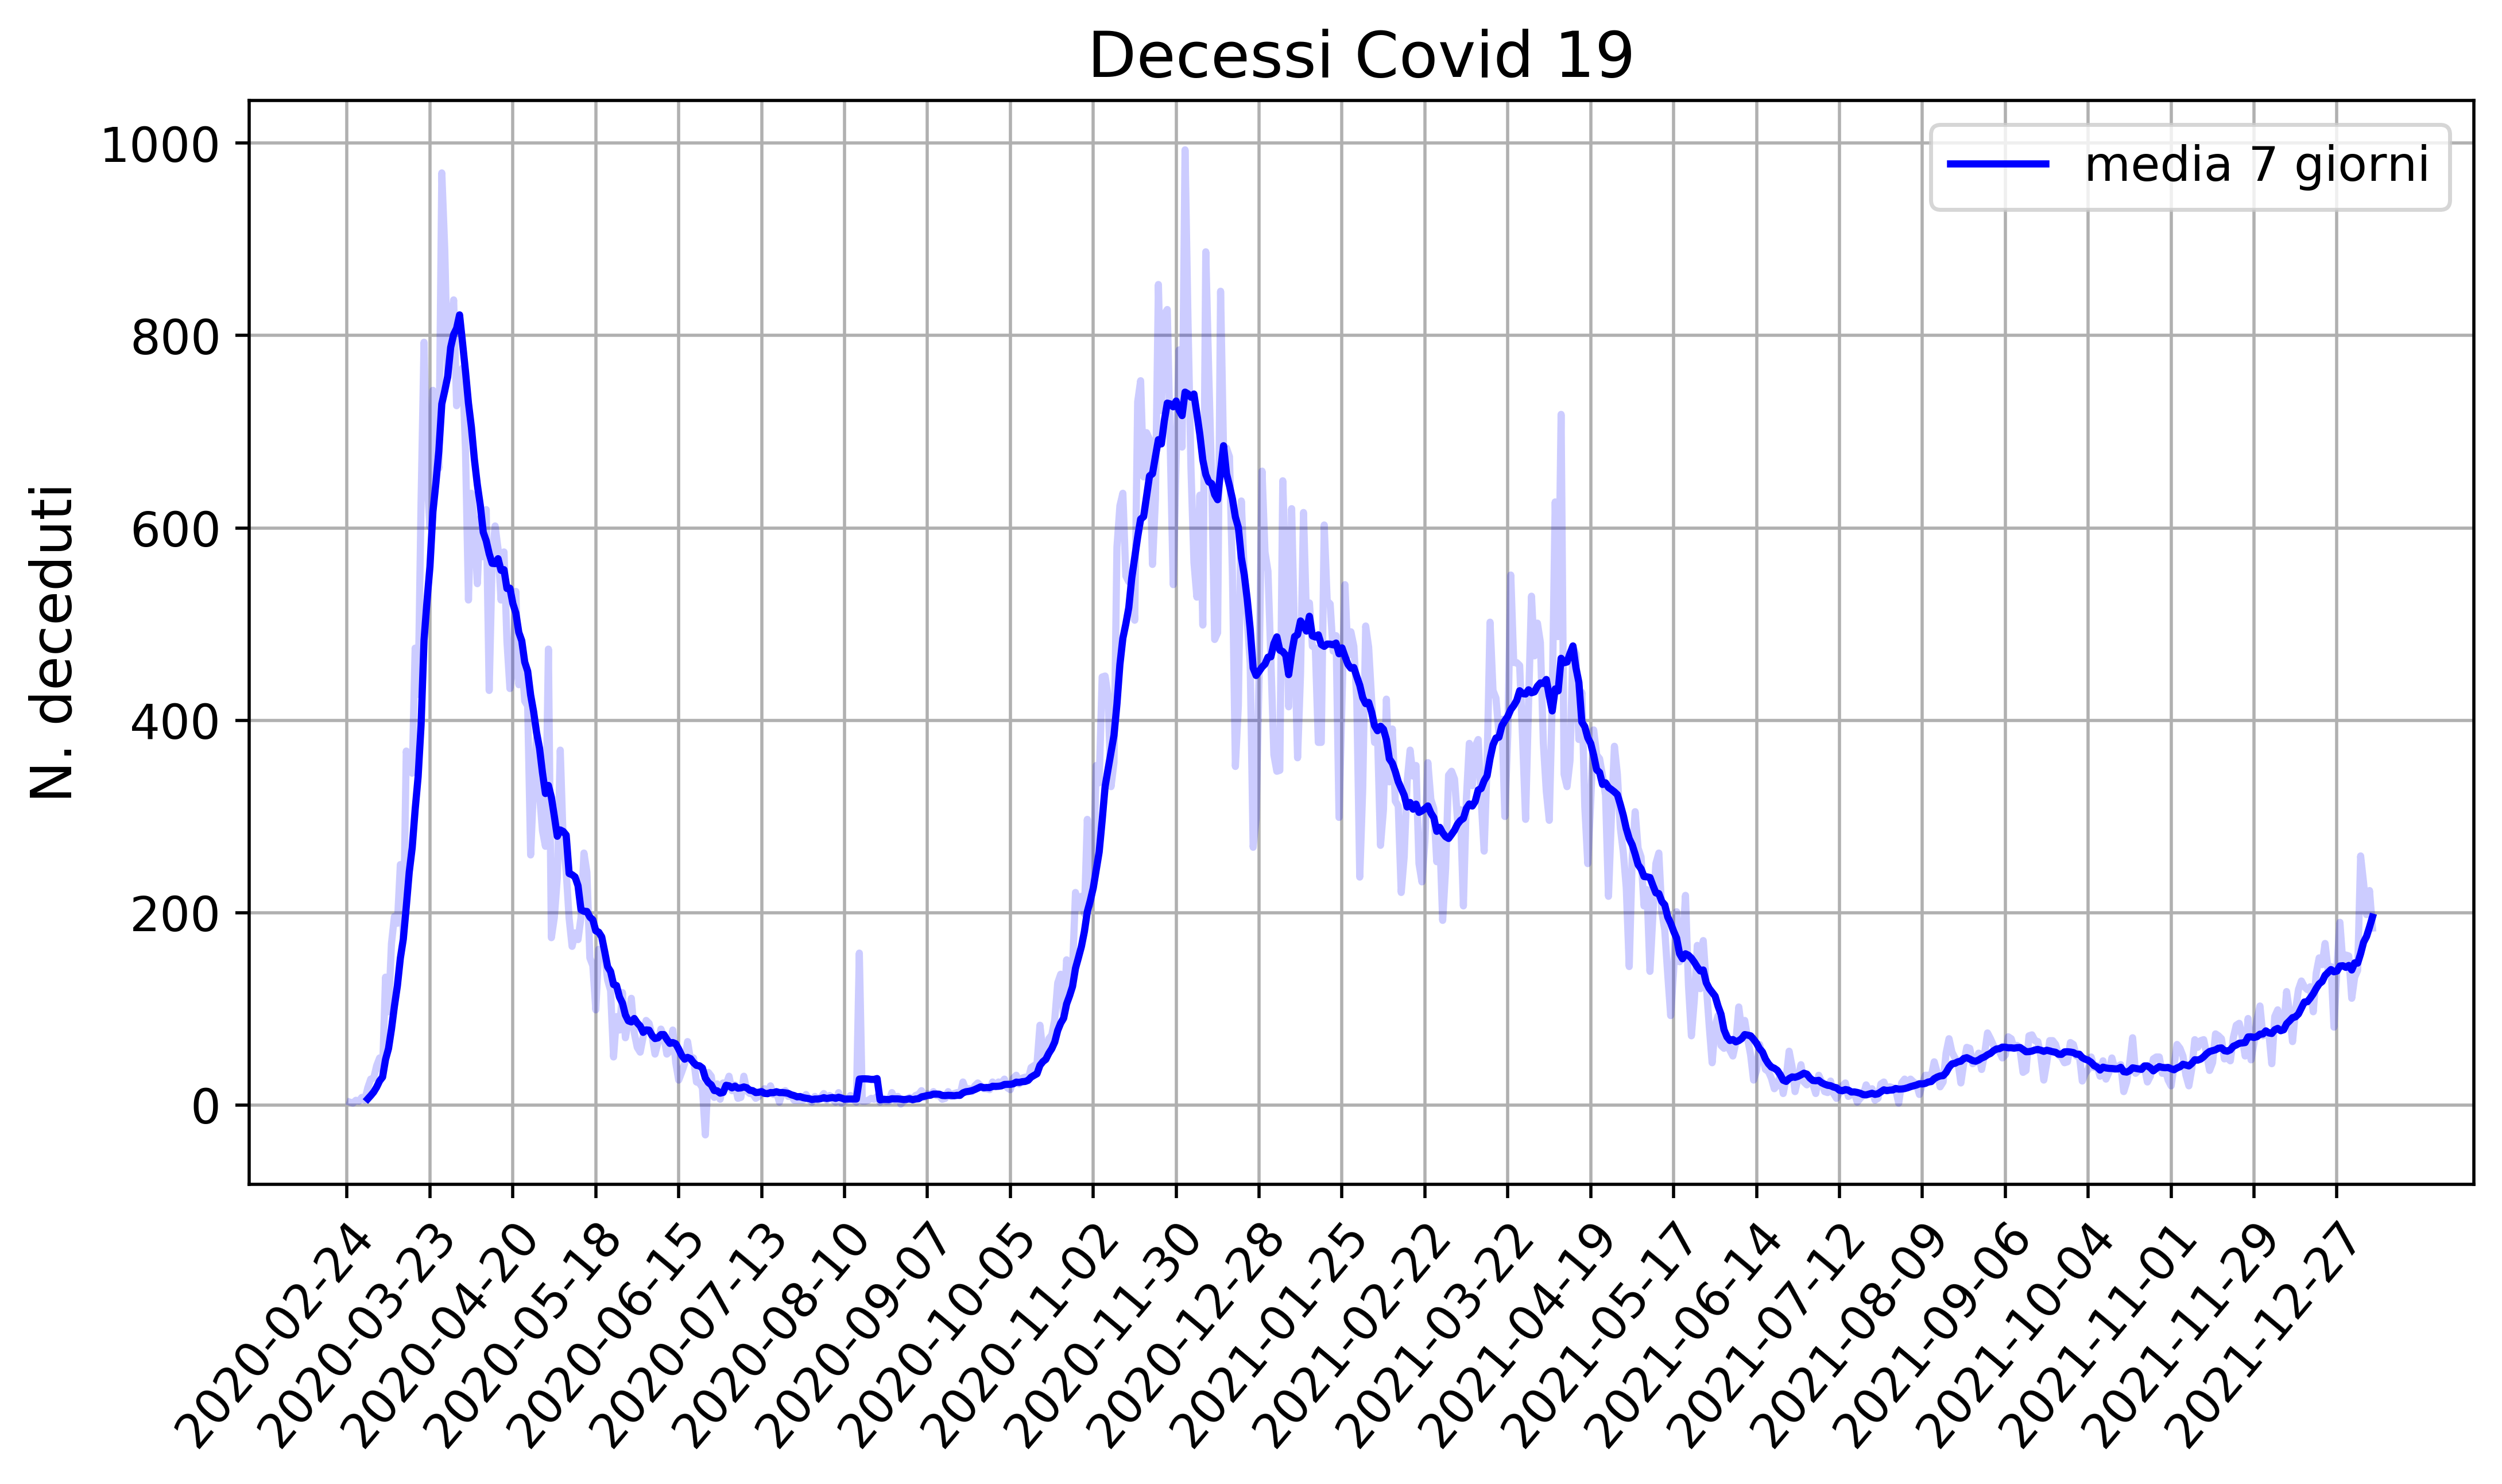

In [28]:
createXYPlot(df,
             y=["variazione_deceduti","variazione_deceduti_media_7"],
             labels=[None,"media 7 giorni"],
             x="giorno",
             ytitle="N. deceduti",
             colors=["b","b"],
             alphas=[0.2,1],
             days_interval = 28,
             dpis=500,
             plots_folder=plots_folder,
             linewidth=1.8,
             figsize_x=10,
             figsize_y=5,
             start_date="2020-01-01",
             title="Decessi Covid 19",
             savename="deceduti"
            )

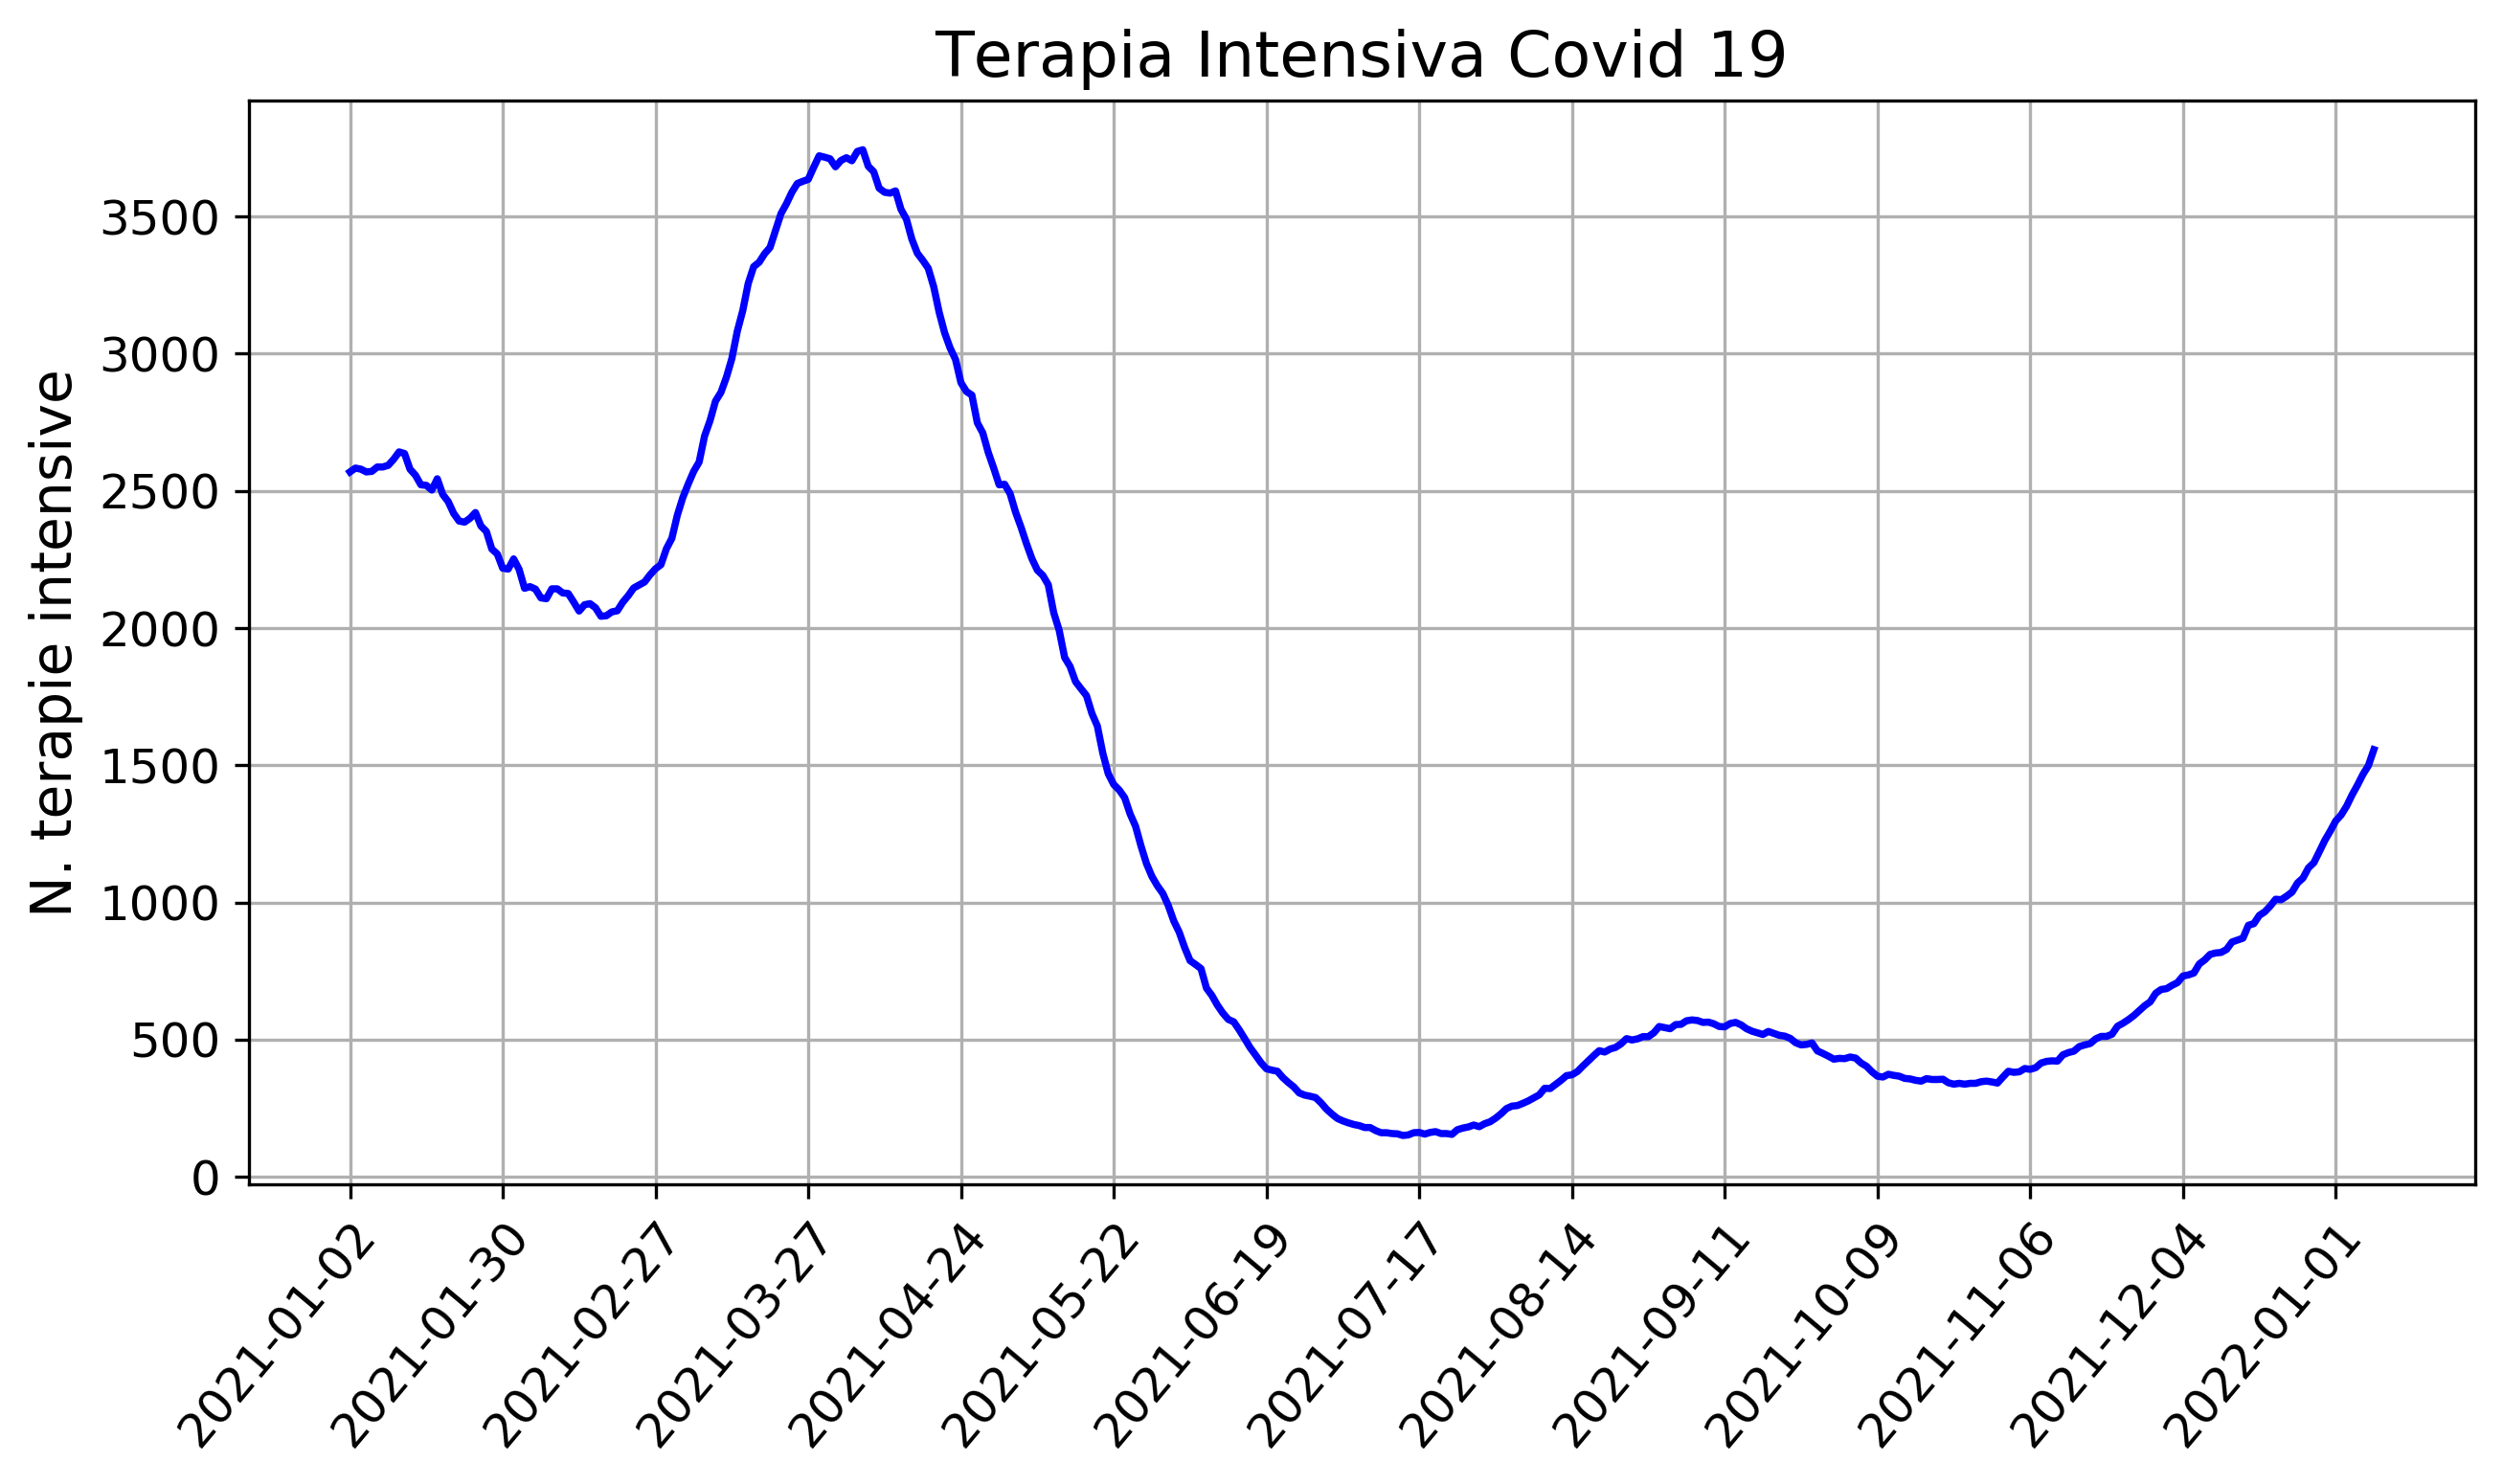

In [36]:
createXYPlot(df,
             y=["terapia_intensiva"],
             labels=["terapia intensiva"],
             x="giorno",
             ytitle="N. terapie intensive",
             colors=["b"],
             alphas=[1],
             days_interval = 28,
             dpis=300,
             plots_folder=plots_folder,
             linewidth=1.8,
             figsize_x=10,
             figsize_y=5,
             start_date="2021-01-01",
             title="Terapia Intensiva Covid 19",
             savename="terapia_intensiva"
            )

In [31]:
df["terapia_intensiva_x10"] = 10*df["terapia_intensiva"]

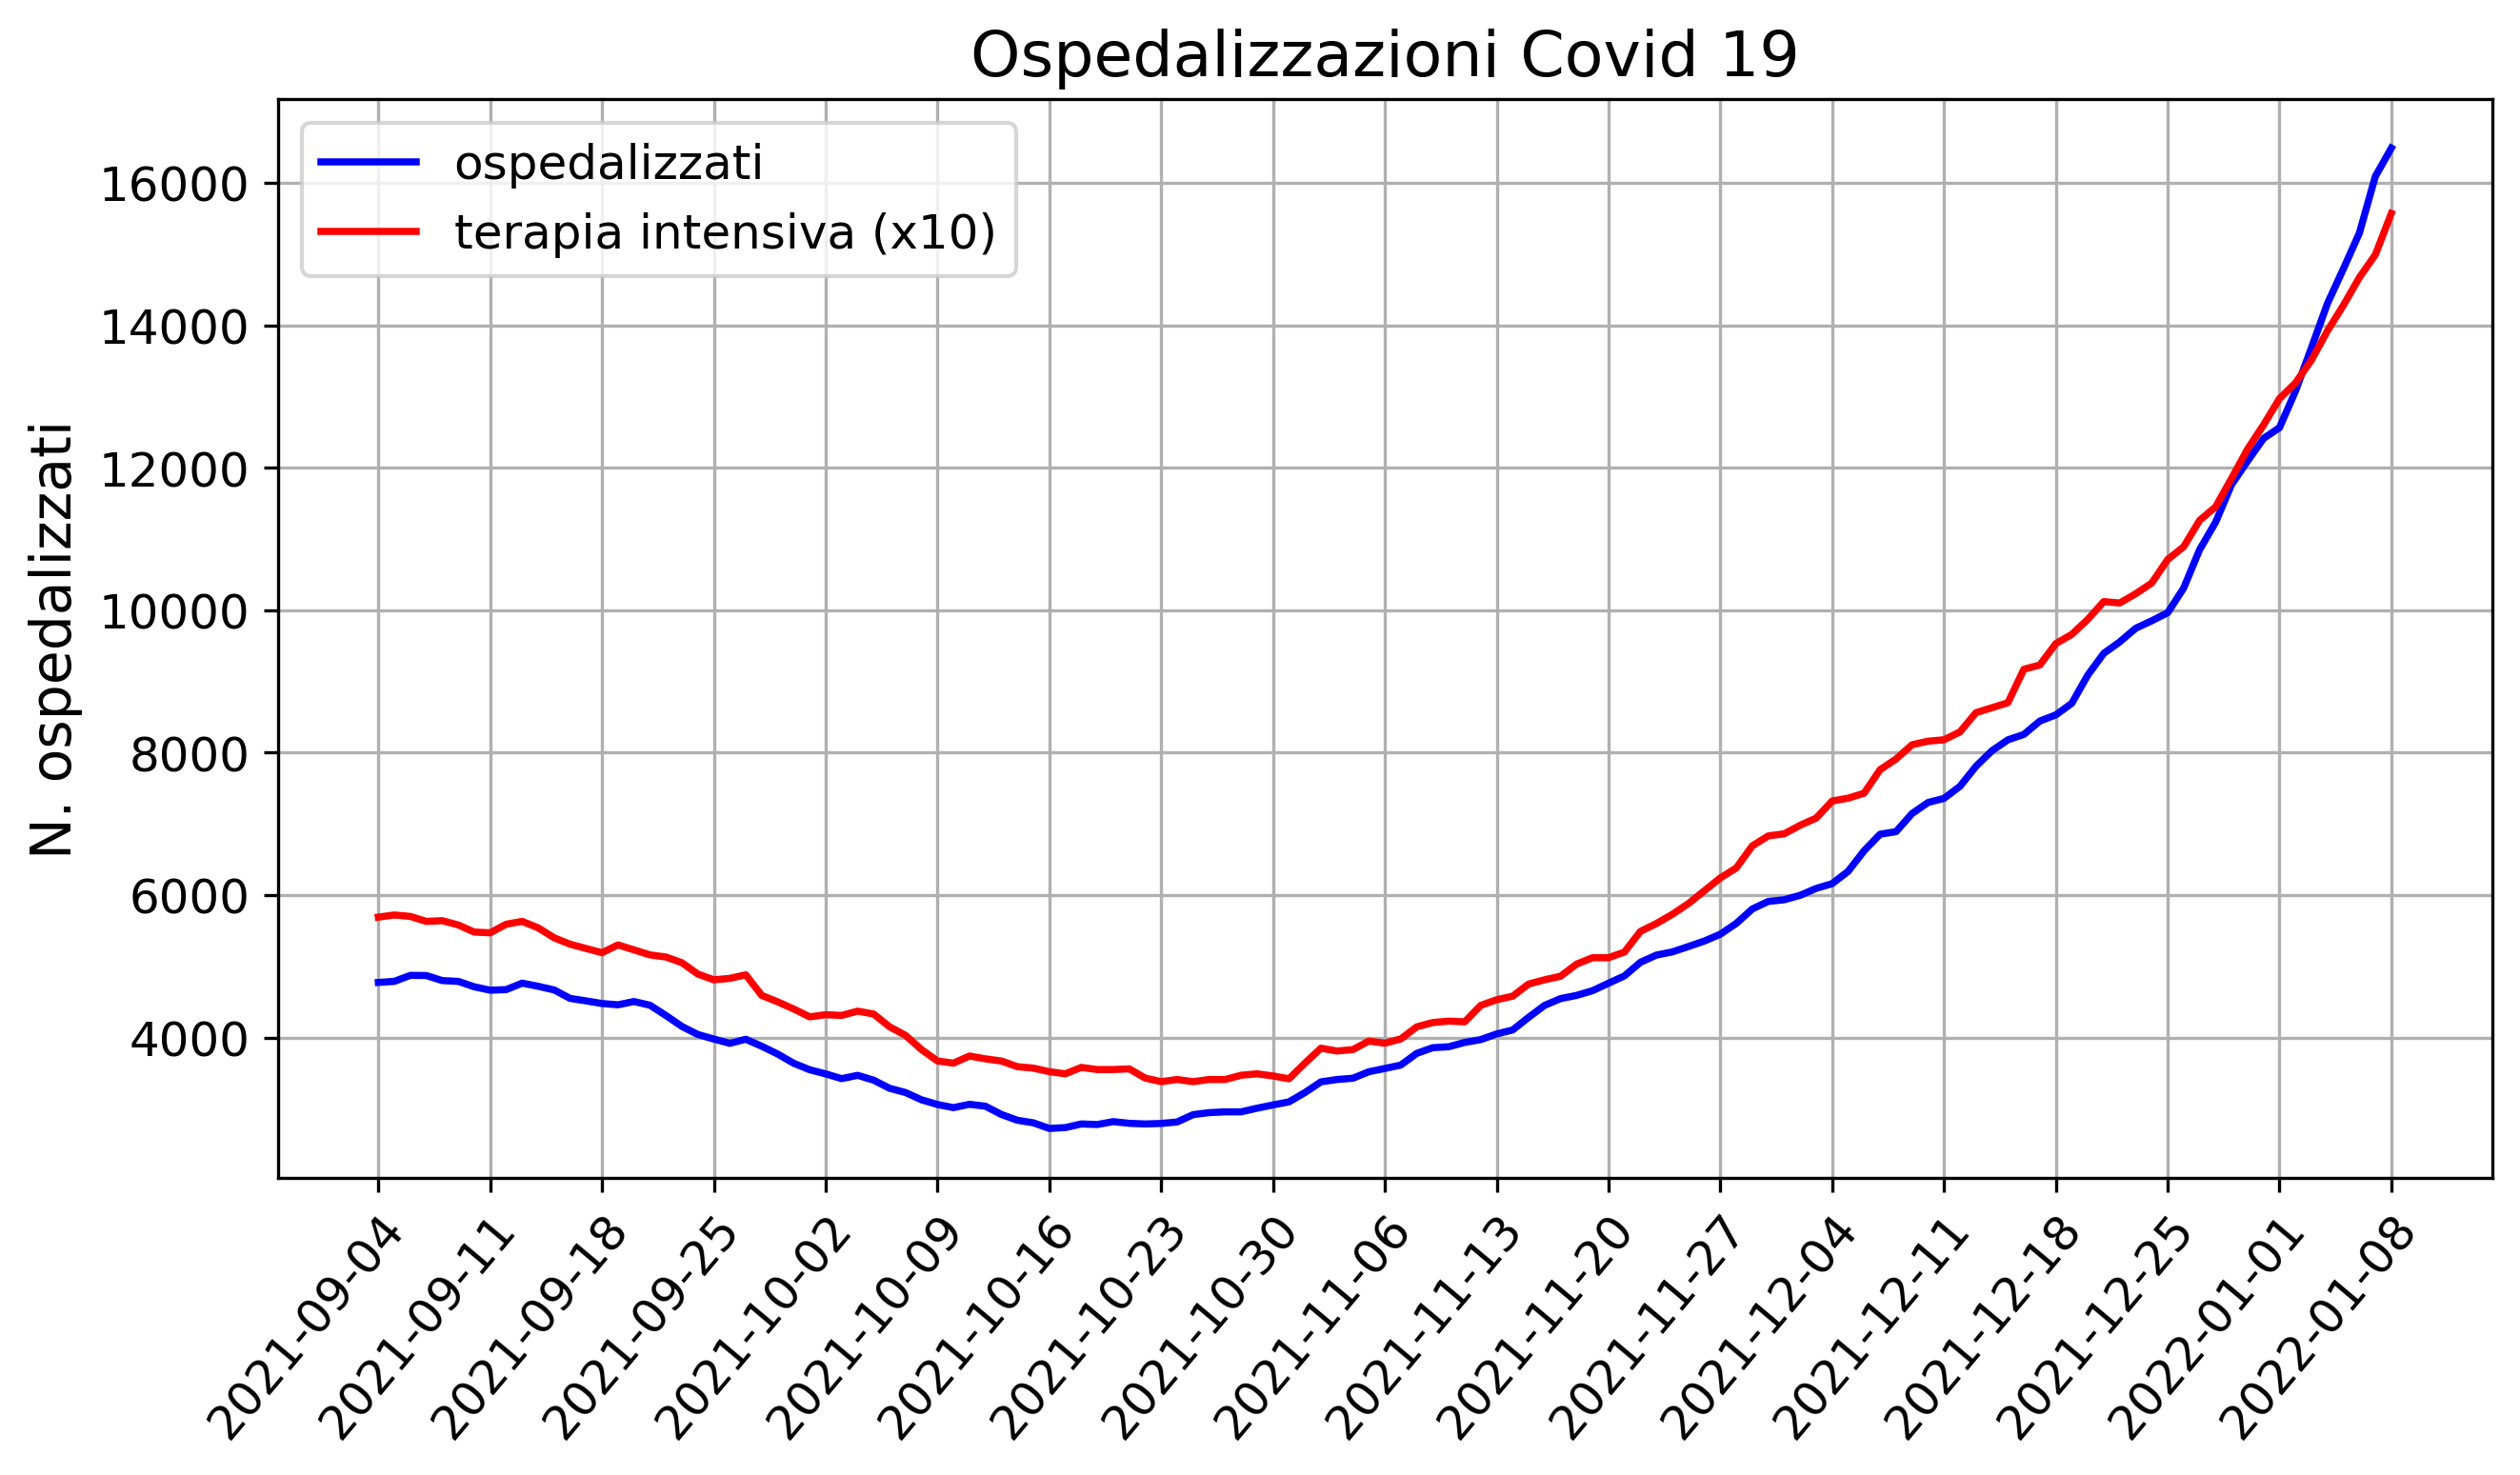

In [35]:
createXYPlot(df,
             y=["totale_ospedalizzati", "terapia_intensiva_x10"],
             labels=["ospedalizzati", "terapia intensiva (x10)"],
             x="giorno",
             ytitle="N. ospedalizzati",
             colors=["b","r"],
             alphas=[1,1],
             days_interval = 7,
             dpis=300,
             plots_folder=plots_folder,
             linewidth=1.8,
             figsize_x=10,
             figsize_y=5,
             start_date="2021-09-03",
             title="Ospedalizzazioni Covid 19",
             savename="ospedalizzazioni_ti",
             yscale="linear"
            )

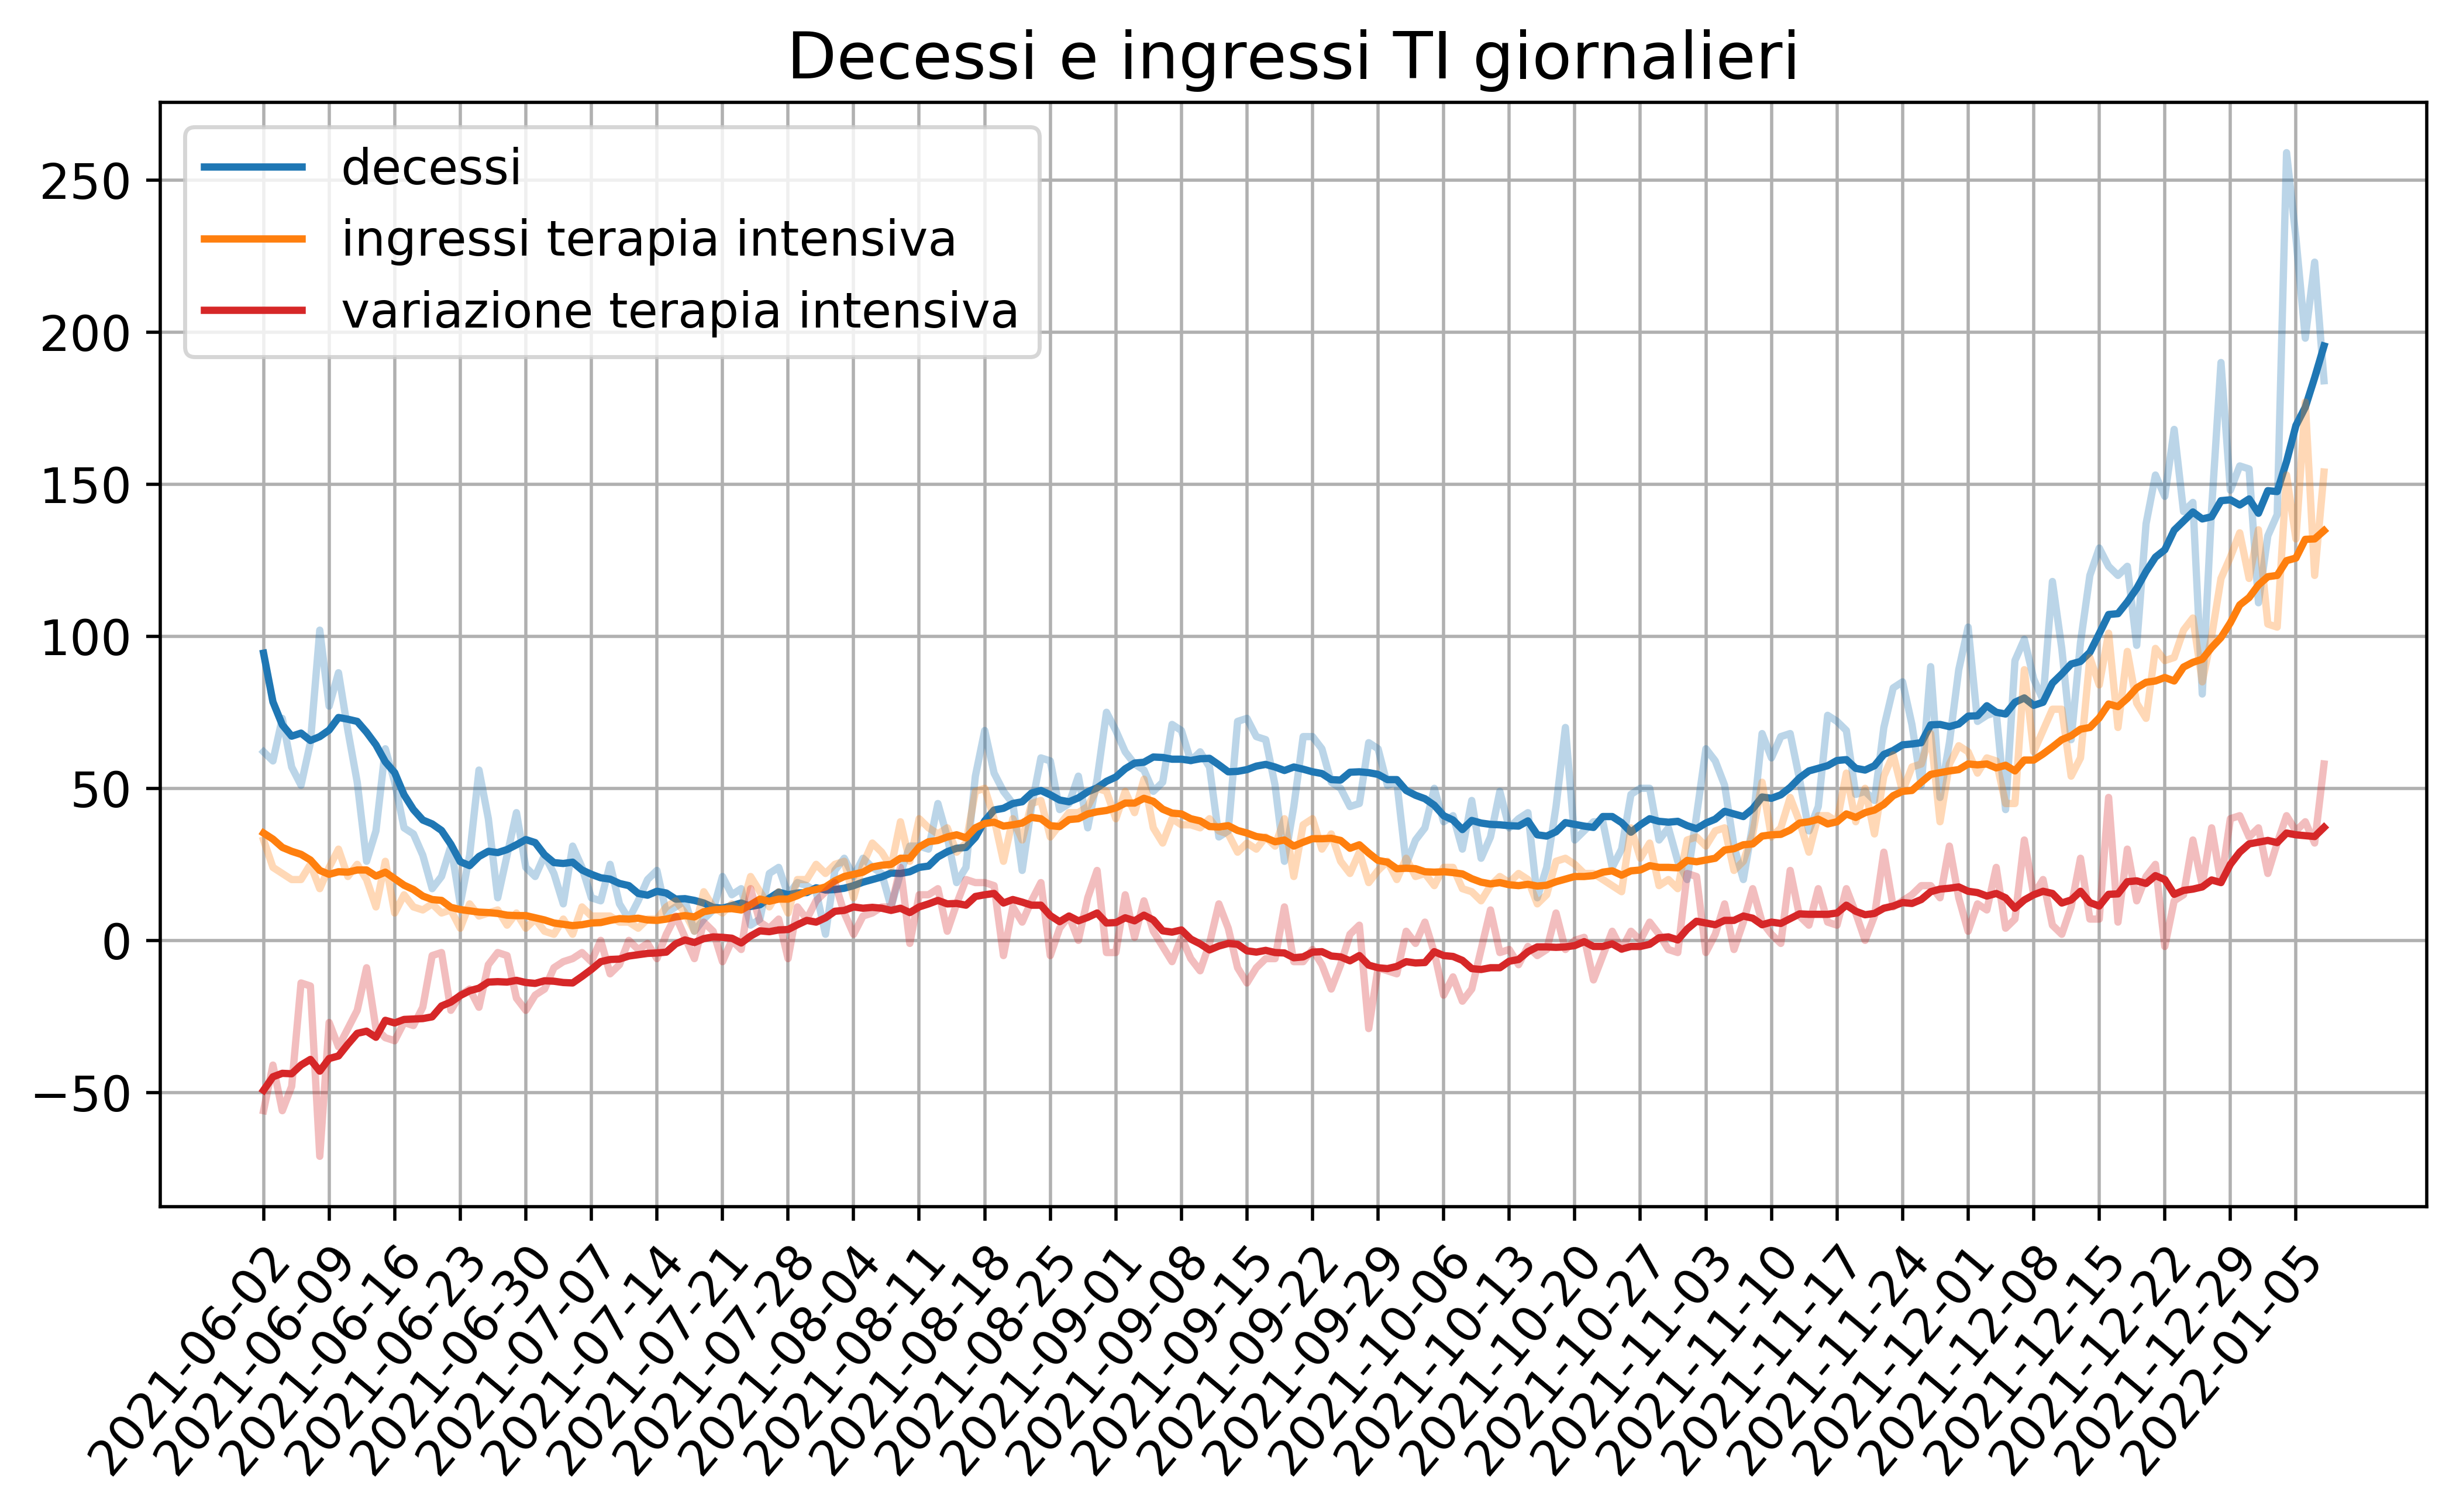

In [34]:
createXYPlot(df,
             y=["variazione_deceduti",
                "variazione_deceduti_media_7",
                "ingressi_terapia_intensiva",
                "ingressi_terapia_intensiva_media_7",
                "variazione_terapia_intensiva",
                "variazione_terapia_intensiva_media_7",
               ],
             x="giorno",
             ytitle="",
             alphas=[0.3,1,0.3,1,0.3,1],
             colors=[colors[0],colors[0],colors[1],colors[1],colors[3],colors[3]],
             labels=[
                 None,"decessi",
                 None,"ingressi terapia intensiva",
                 None,"variazione terapia intensiva"
             ],
             days_interval = 7,
             dpis=500,
             plots_folder=plots_folder,
             linewidth=1.8,
             figsize_x=10,
             figsize_y=5,
             start_date="2021-06-01",
             title="Decessi e ingressi TI giornalieri",
             savename="deceduti_ingressi_ti.png")

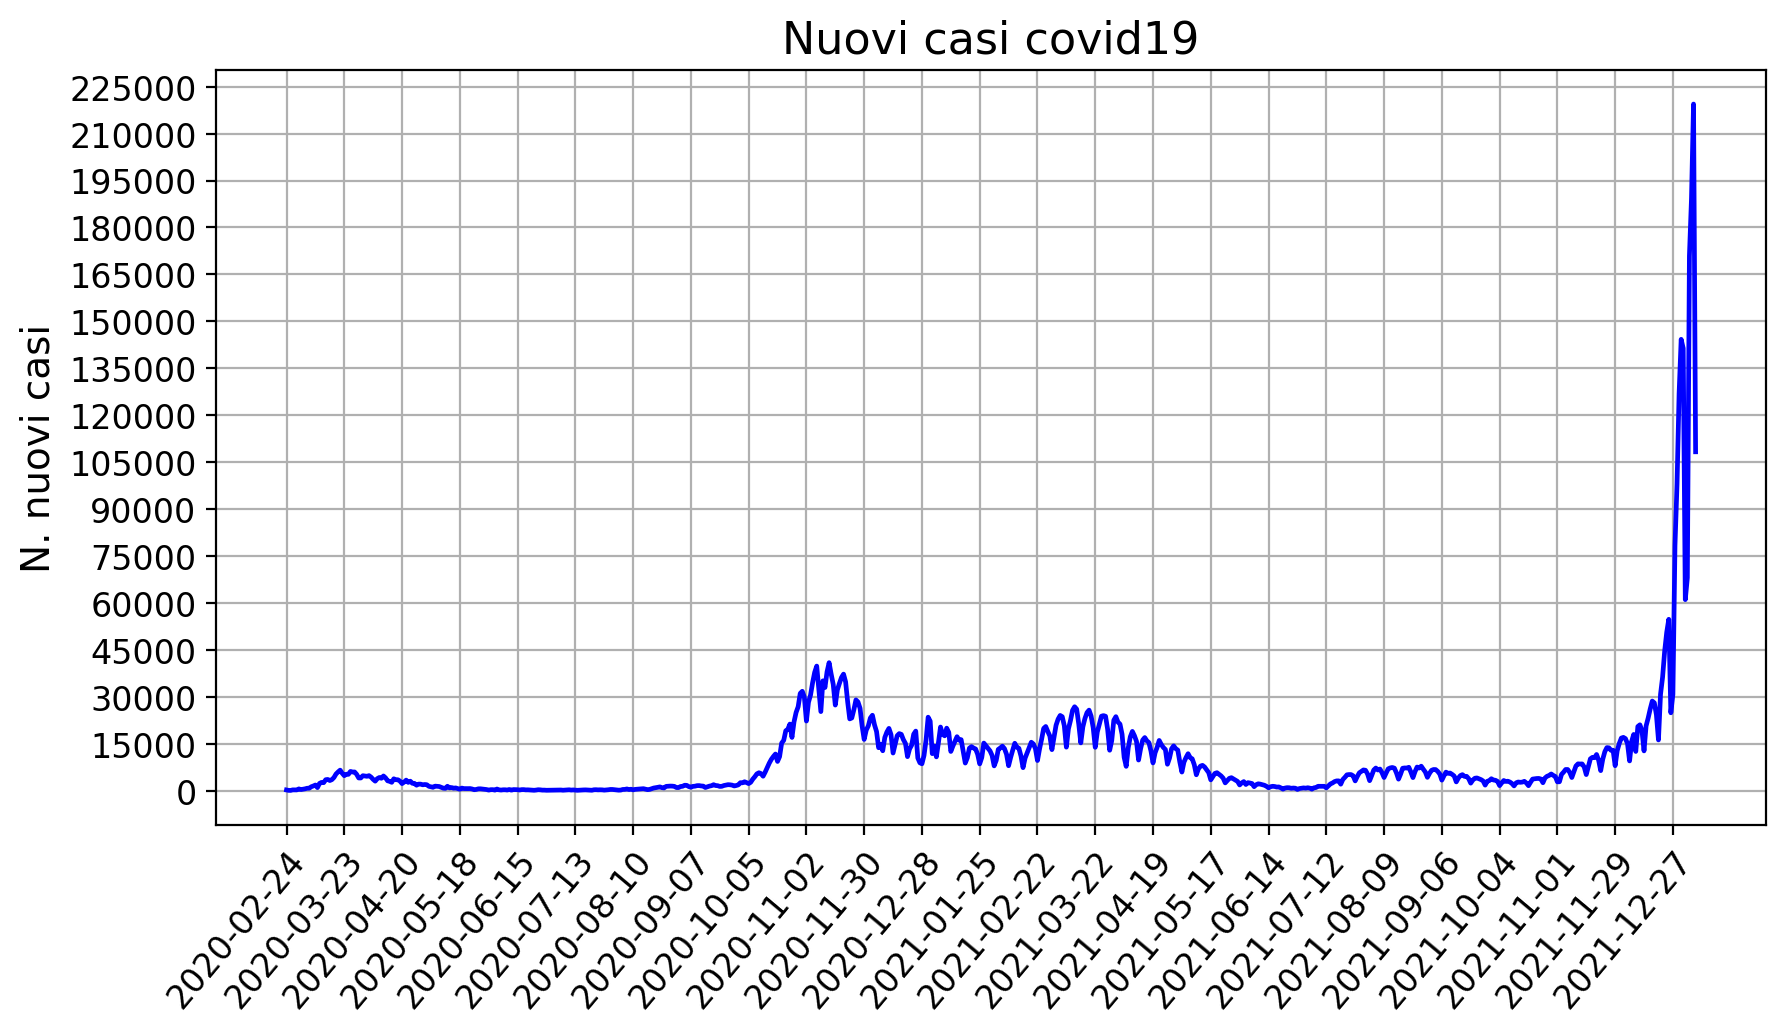

In [31]:
createXYPlot(df,
             y=["nuovi_positivi"],
             labels=["nuovi positivi"],
             x="giorno",
             ytitle="N. nuovi casi",
             alphas=[1],
             colors=["b"],
             today=oggi,
             days_interval = 28,
             dpis=200,
             plots_folder=plots_folder,
             linewidth=1.7,
             yticks=np.arange(0,230000,15000),
             start_date="2020-01-01",
             title="Nuovi casi covid19",
             savename="nuovi_positivi.png",
            )

In [32]:
z_value = 1.645
df1 = (df[["data","deceduti","totale_casi","giorno", "totale_ospedalizzati"]]
       .groupby(df["data"].dt.strftime("%m-%y"))
       .head(1).reset_index().drop(columns=["index"]))


df1["deceduti_mese"] = df1["deceduti"] - df1["deceduti"].shift(-1) 
df1["deceduti_mese"] = df1.deceduti_mese.combine_first(df1.deceduti)  

df1["casi_mese"] = df1["totale_casi"] - df1["totale_casi"].shift(-1) 
df1["casi_mese"] = df1.casi_mese.combine_first(df1.totale_casi)                                     

df1["letalità_mese"]=np.round(100*df1["deceduti_mese"]/df1["casi_mese"],2)
df1["tasso_ospedalizzazione_mese"]=np.round(100*df1["totale_ospedalizzati"]/df1["casi_mese"],2)

df1=df1.sort_values(by=["data"])
df1["data_plot"] = df1["data"].dt.strftime("%B-%Y")

df1["sd_letalità_mese"] = z_value*np.round(100*np.sqrt(df1["letalità_mese"])/np.sqrt(df1["casi_mese"]),2)
df1["sd_tasso_ospedalizzazione_mese"] = z_value*np.round(100*np.sqrt(df1["tasso_ospedalizzazione_mese"])/np.sqrt(df1["casi_mese"]),2)

df1["letalità_up_err"] = df1["sd_letalità_mese"]
df1["letalità_lo_err"] = np.where(df1['sd_letalità_mese'] > df1['letalità_mese'],df1['letalità_mese'], df1['sd_letalità_mese'])

df1["tasso_ospedalizzazione_up_err"] = df1["sd_tasso_ospedalizzazione_mese"]
df1["tasso_ospedalizzazione_lo_err"] = np.where(df1['sd_tasso_ospedalizzazione_mese'] > df1['tasso_ospedalizzazione_mese'],df1['tasso_ospedalizzazione_mese'], df1['sd_tasso_ospedalizzazione_mese'])

df1["year"] = df1["data"].dt.strftime("%Y")
df1["month"] = df1["data"].dt.strftime("%B")
df1["month_num"] = df1["data"].dt.strftime("%m").astype(int)



df1_2020 = df1[df1.year=='2020'].set_index("month_num")
df1_2021 = df1[df1.year=='2021'].set_index("month_num")
df1_2020_2021 = df1_2020.join(df1_2021,lsuffix="_2020",rsuffix="_2021",how="outer").reset_index()

import calendar
month_dict={i:list(calendar.month_name)[i] for i in range(1,13)}
print(month_dict)

df1_2020_2021["month"]=df1_2020_2021["month_num"].replace(month_dict)

{1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}


In [74]:
def get_montly_plot(x):
    asymmetric_error = [df1[f"{x}_lo_err"],df1[f"{x}_up_err"]]

    max_val = int(np.max(df1[f"{x}_mese"])) + int(np.max(df1[f"{x}_up_err"]))
    fig,ax=plt.subplots(dpi=200,figsize=(11,5))
    plt.bar(df1["data_plot"],df1[f"{x}_mese"],alpha=0.8)
    plt.errorbar(x=df1["data_plot"],y=df1[f"{x}_mese"],
             yerr=asymmetric_error,
             fmt='o',color="black",lolims=0,
            linewidth=0.8,capsize=3,markersize=3)
    for i, v in enumerate(df1[f"{x}_mese"]):
        ax.text(i+0.1, v+0.2, f"{np.round(v,2)}%", horizontalalignment="left",rotation=40)
    plt.grid()
    _=plt.yticks(np.arange(0,max_val,5),fontsize=12)
    plt.ylabel(f"{x} [%]".replace("_"," "),fontsize=15)
    _=plt.xticks(rotation=60, fontsize=12,
             rotation_mode="anchor", 
           verticalalignment = "top",
           horizontalalignment = "right")
    pltpath=f"./plots/{oggi}/{x}_mese.png"
    plt.title(f"{x} COVID-19 per mese".replace("_"," "),fontsize=16)
    plt.savefig(pltpath,bbox_inches="tight")

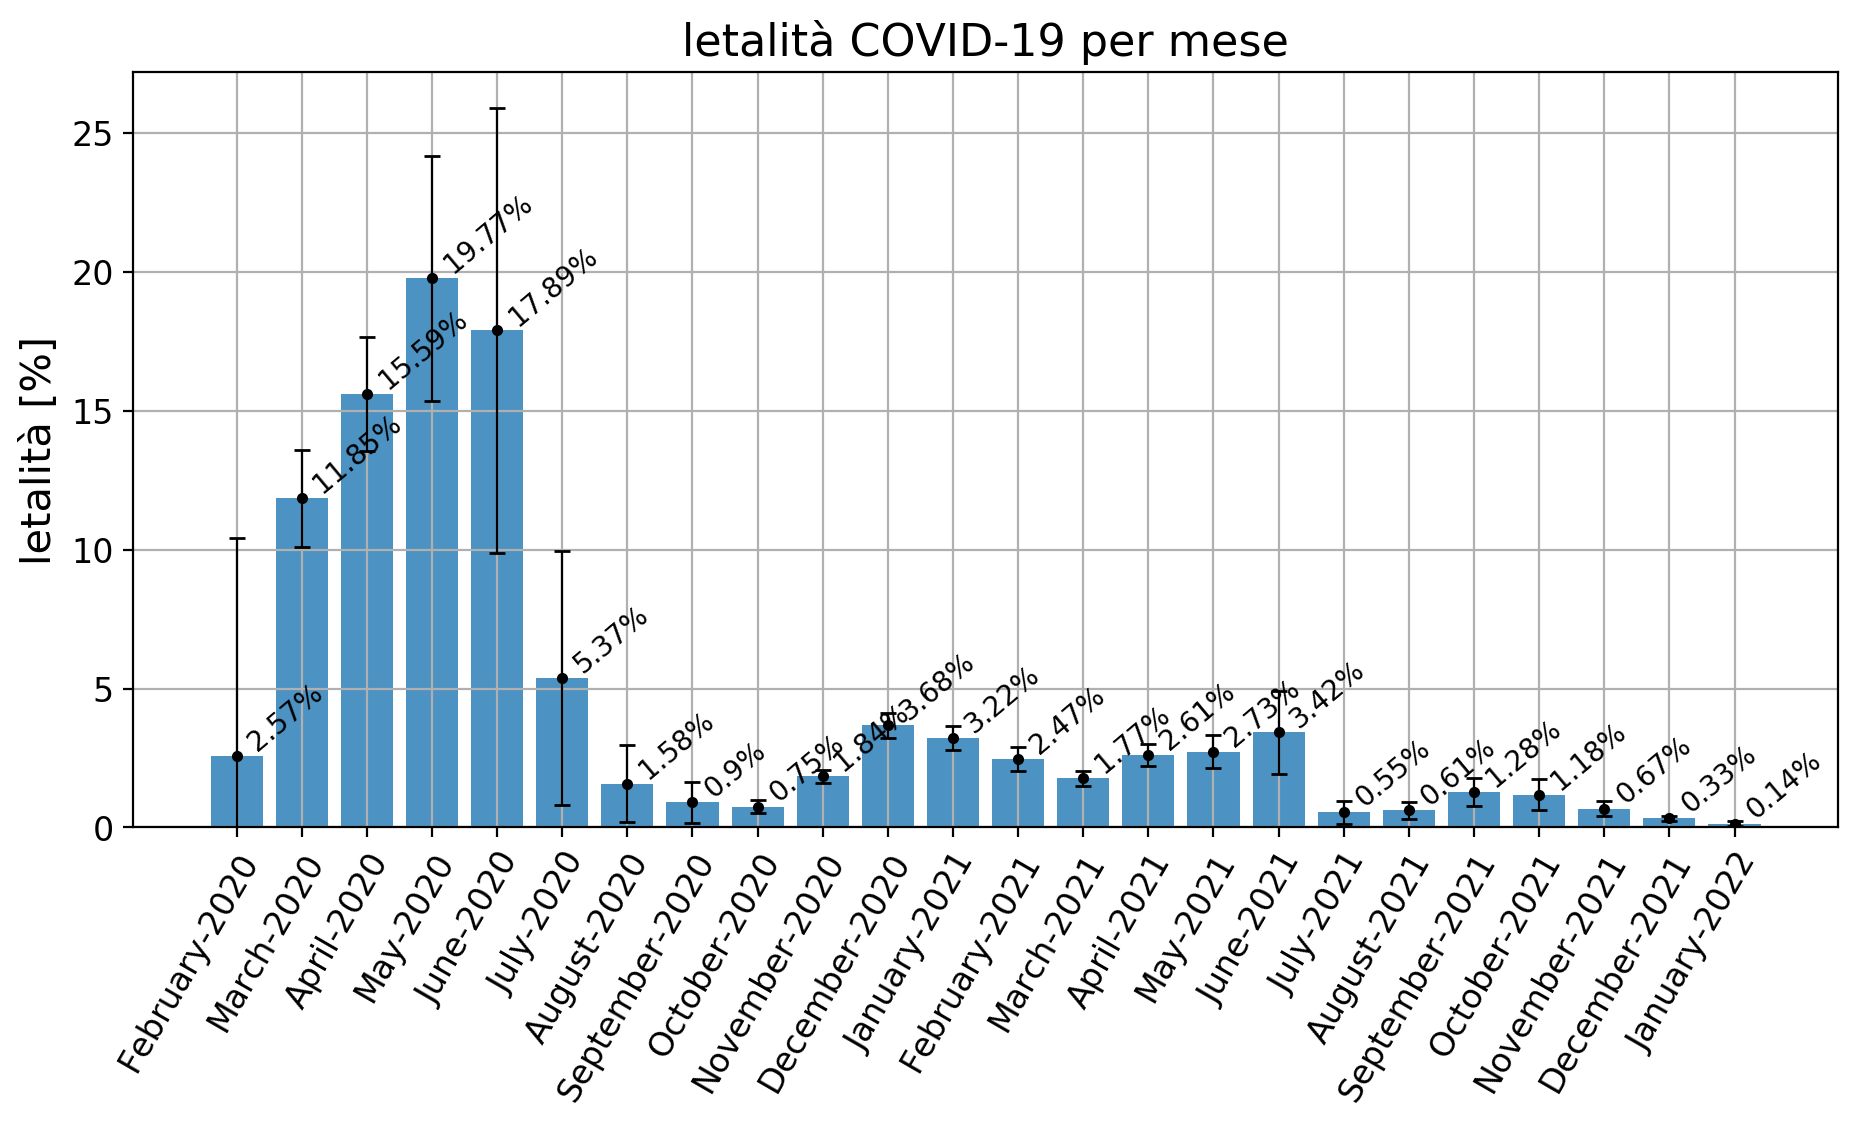

In [75]:
get_montly_plot(x="letalità")

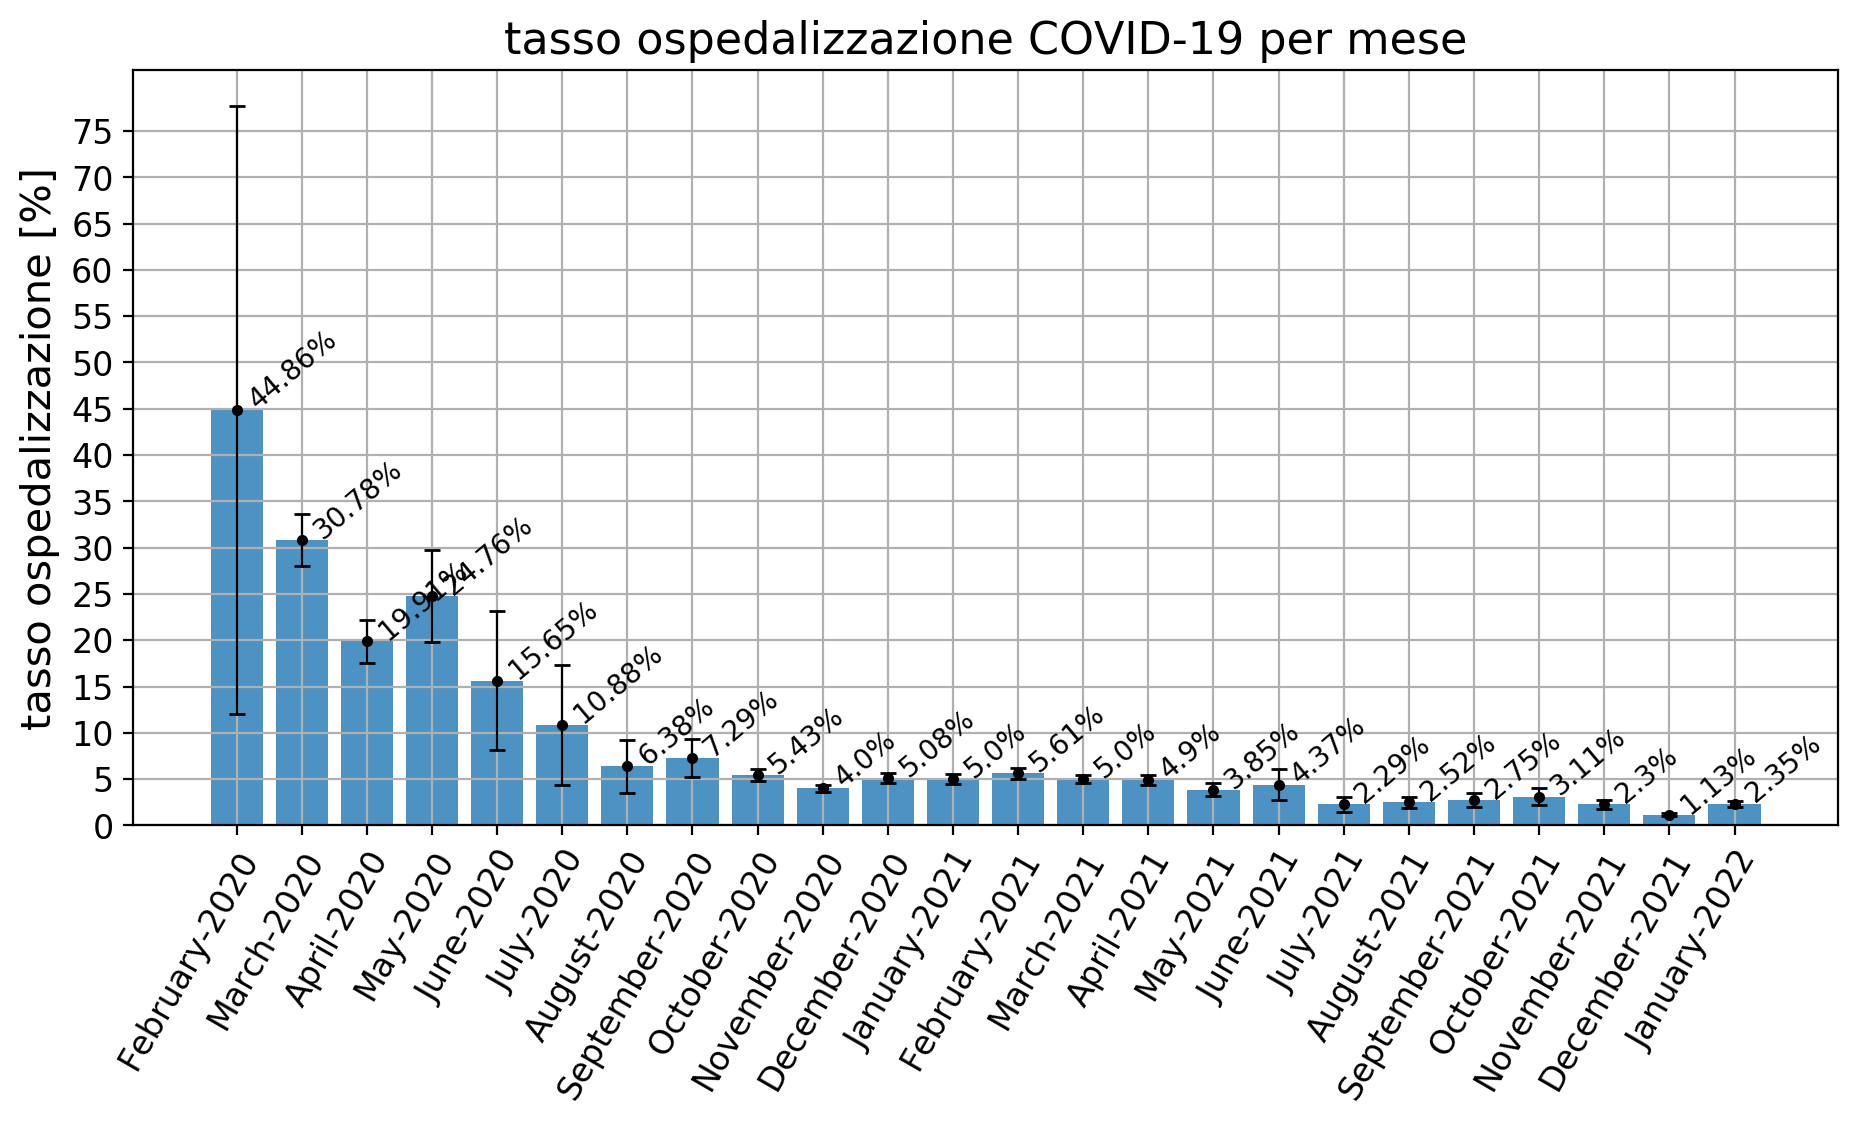

In [76]:
get_montly_plot(x="tasso_ospedalizzazione")

In [77]:
def get_range(n):
    if n % 2 == 0:
        r_plus = list(np.arange(n/2+1))
        r_plus.remove(0)
        r_minus = sorted([-x for x in r_plus])
        return r_minus + r_plus
    else: 
        r_plus = list(np.arange(n/2+1))
        r_minus = sorted([-x for x in r_plus])
        return sorted(list(set(r_minus + r_plus)))

In [33]:
def make_hist_comp(x):
    fig, ax = plt.subplots(figsize=(12,5),dpi=100)
    width=0.4
    
    years = [x.split("_")[1] for x in df1_2020_2021.columns if "year" in x]
    steps = get_range(len(years))
    for i in range(0,len(years)):
        asymmetric_error = [df1_2020_2021[f"{x}_lo_err_{years[i]}"],df1_2020_2021[f"{x}_up_err_{years[i]}"]]
        plt.bar(df1_2020_2021.month_num + steps[i]*(width/2), 
                df1_2020_2021[f"{x}_mese_{years[i]}"],
                alpha=0.8,align="center",width=width, label=years[i])
        plt.errorbar(x=df1_2020_2021.month_num + steps[i]*(width/2),
                     y=df1_2020_2021[f"{x}_mese_{years[i]}"],
                     yerr=asymmetric_error,
                     fmt='o',color="black",lolims=0,
                     linewidth=0.8,capsize=3,markersize=3)
    plt.legend(fontsize=13)
    _ = plt.xticks(list(np.arange(1,13,1)),
                   rotation=60, fontsize=13,
                   rotation_mode="anchor", 
                   verticalalignment = "top",
                   horizontalalignment = "right")
    _ = ax.set_xticklabels(df1_2020_2021.month.values)
    _ = plt.yticks(fontsize=13)
    plt.title(x.replace("_"," "),fontsize=18)
    plt.ylabel("[%]",fontsize=14)
    plt.grid()
    pltpath=f"./plots/{oggi}/year_comp_{x}.png"
    plt.savefig(pltpath,bbox_inches="tight")

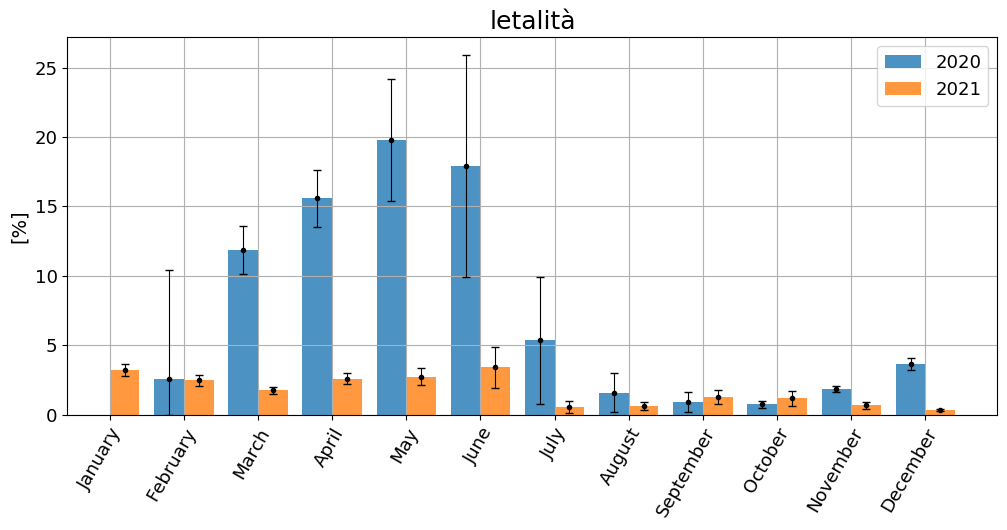

In [34]:
make_hist_comp("letalità")

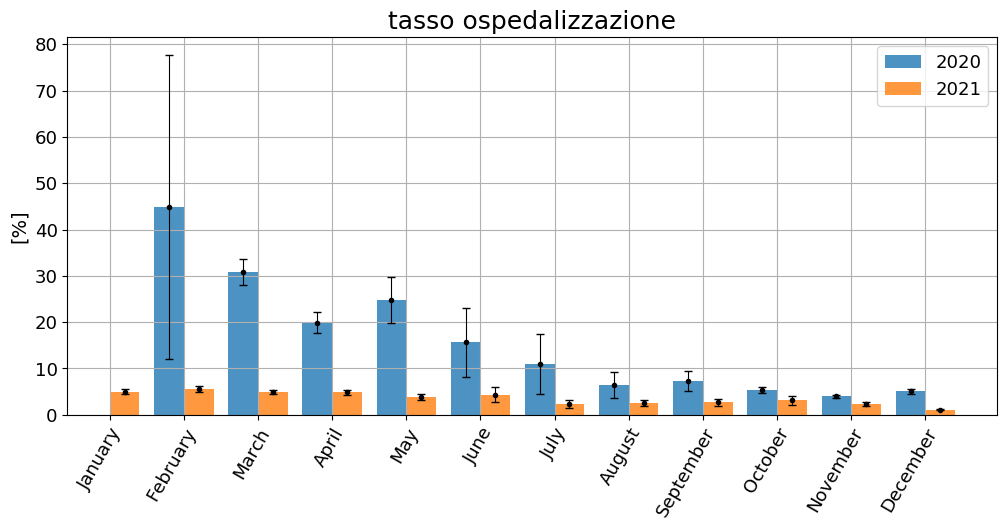

In [35]:
make_hist_comp("tasso_ospedalizzazione")

### Confronto anni

In [33]:
df_anno = df[["data",
              "variazione_deceduti",
              "terapia_intensiva",
              "variazione_deceduti_media_7",
              "totale_ospedalizzati",
              "variazione_tamponi",
              "variazione_tamponi_media_7",
              "nuovi_positivi",    
              "nuovi_positivi_media_7",
              "totale_positivi",
              "tasso_positivi",
              "tasso_positivi_media_7"
             ]]

df_anno["anno"] = pd.DatetimeIndex(df_anno['data']).year
df_anno["giorno"] = df_anno['data'].dt.dayofyear
df_anno["settimana"] = df_anno['data'].dt.weekofyear

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [34]:
df_dict = {}
years = [2020,2021,2022]
for year in years:
    df_dict[year] = df_anno[df_anno.anno == year].sort_values(by="giorno").reset_index()

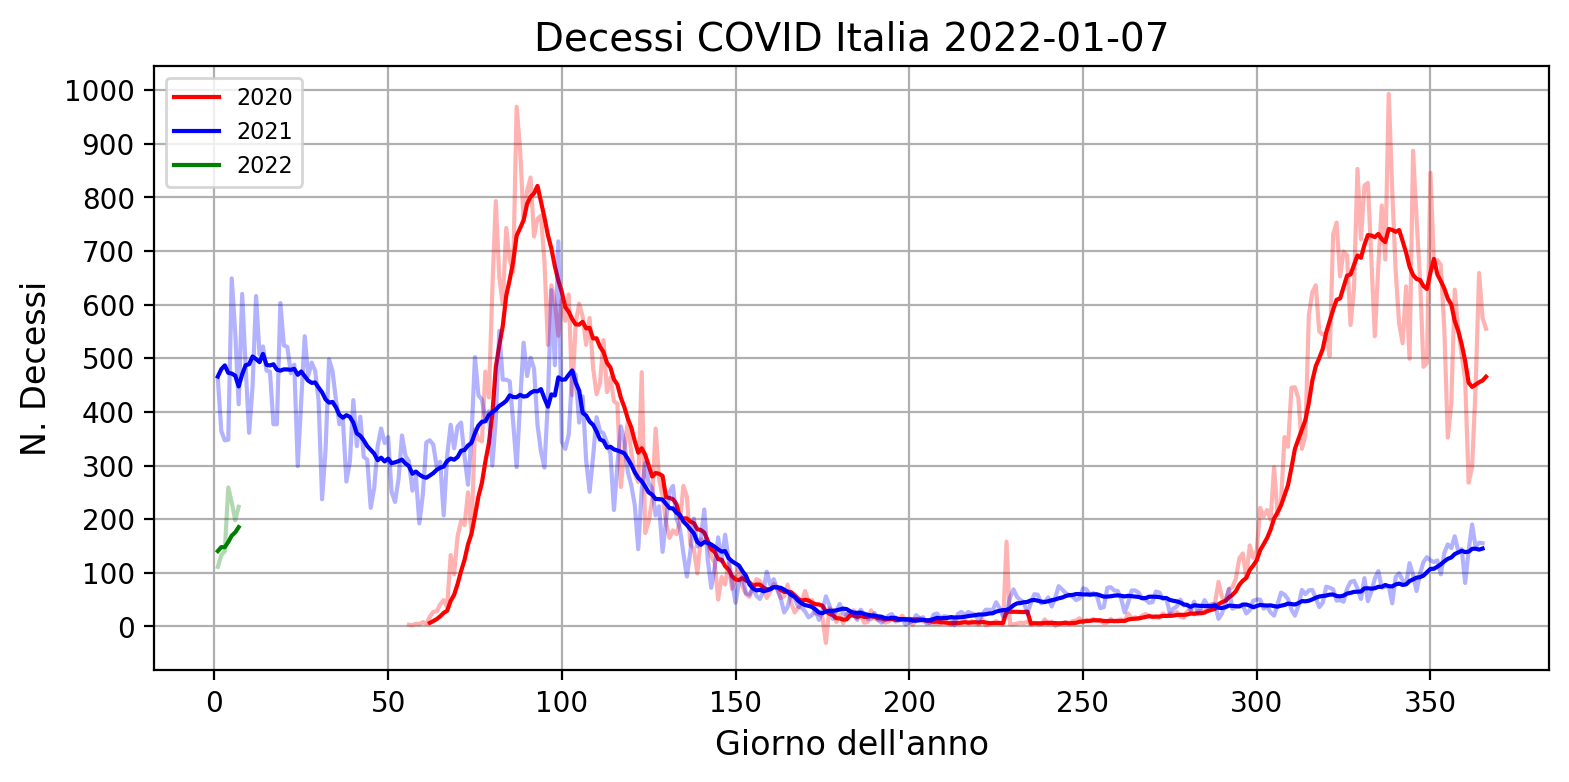

In [35]:
plt.figure(dpi=200,figsize=(9,4))
colors = ["r","b","g"]
i=0
for year in years:
    plt.plot(df_dict[year]["giorno"],df_dict[year]["variazione_deceduti"],alpha=0.3,color=colors[i])
    plt.plot(df_dict[year]["giorno"],df_dict[year]["variazione_deceduti_media_7"],label=year,alpha=1,color=colors[i])
    i+=1
    
plt.grid()
plt.title(f"Decessi COVID Italia {oggi}",fontsize=14)
plt.xlabel("Giorno dell'anno",fontsize=12)
plt.ylabel("N. Decessi",fontsize=12)
plt.yticks(np.arange(0,1100,100))
plt.legend(fontsize=8)
plt.savefig(f"./plots/{oggi}/year_comp_decessi.png",bbox_inches="tight")

In [39]:
df.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido', 'dow', 'nuovi_positivi_lag_7',
       'ingressi_terapia_intensiva_lag_7', 'giorno',
       'nuovi_positivi_test_molecolare', 'nuovi_positivi_test_rapido',
       'variazione_deceduti', 'variazione_positivi',
       'variazione_relativa_positivi', 'variazione_deceduti_media_7',
       'variazione_guariti', 'variazione_ospedalizzati',
       'variazione_ricoverati_con_sintomi',
       'variazione_isolamento_domiciliare', 'vari

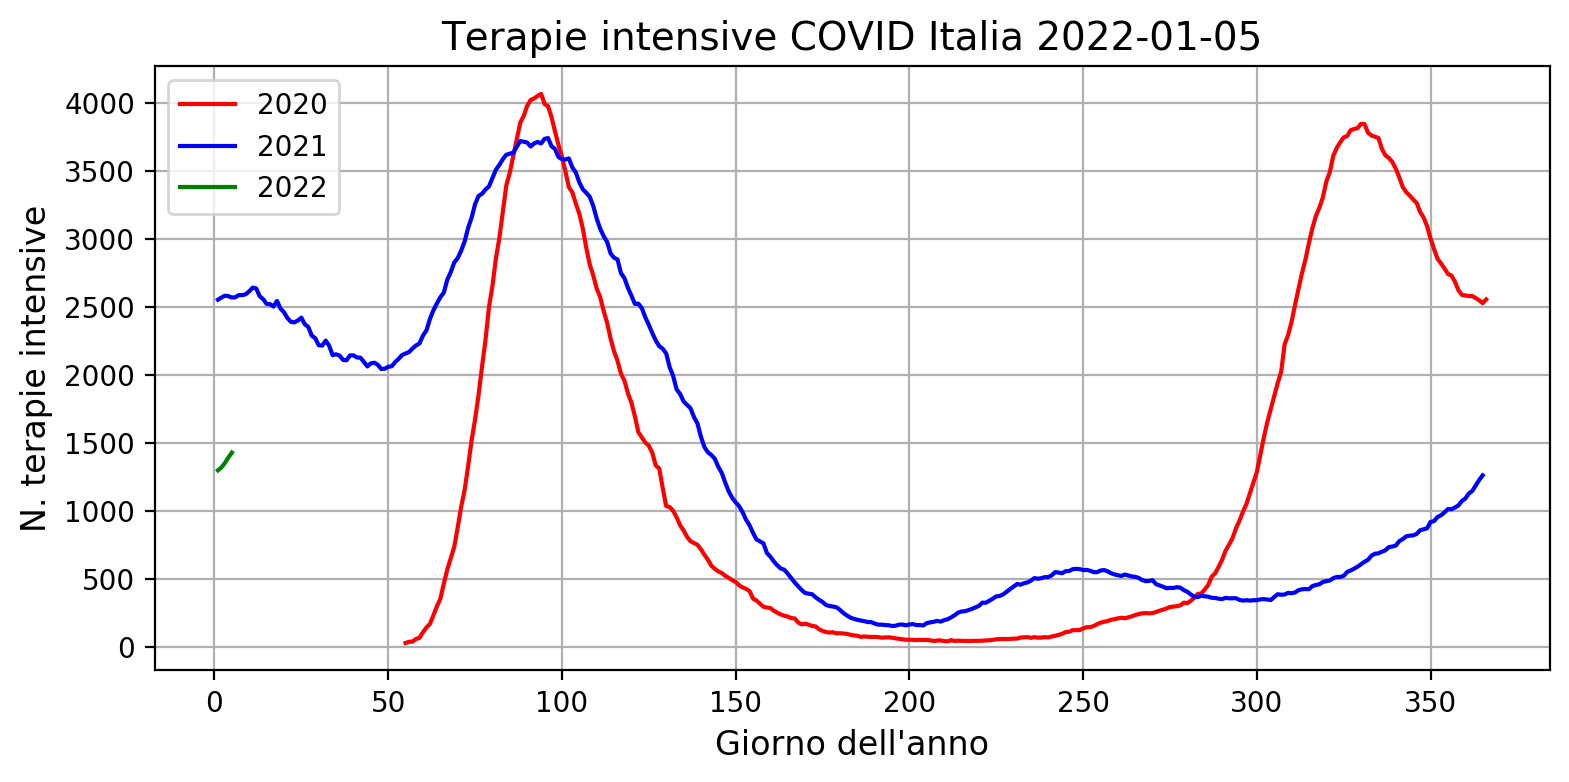

In [81]:
plt.figure(dpi=200,figsize=(9,4))
colors = ["r","b","g"]
i=0
for year in years:
    plt.plot(df_dict[year]["giorno"], df_dict[year]["terapia_intensiva"], alpha=1, color=colors[i], label=year)
    i+=1
plt.grid()
plt.xlabel("Giorno dell'anno",fontsize=12)
plt.ylabel("N. terapie intensive",fontsize=12)
plt.title(f"Terapie intensive COVID Italia {oggi}",fontsize=14)
plt.legend()
plt.savefig(f"./plots/{oggi}/year_comp_ti.png",bbox_inches="tight")

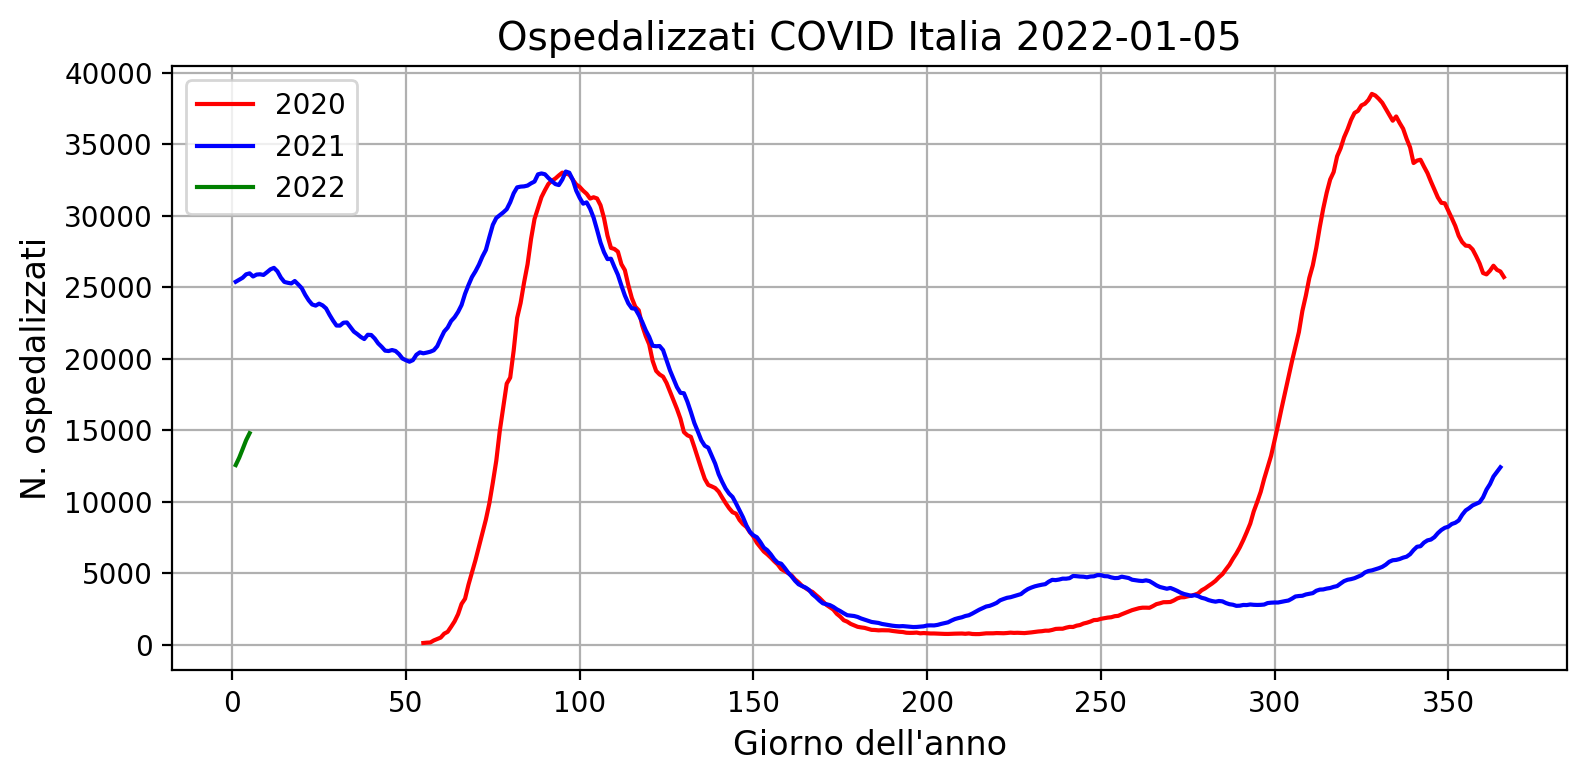

In [83]:
plt.figure(dpi=200,figsize=(9,4))
colors = ["r","b","g"]
i=0
for year in years:
    plt.plot(df_dict[year]["giorno"], df_dict[year]["totale_ospedalizzati"], alpha=1, color=colors[i], label=year)
    i+=1
plt.grid()
plt.xlabel("Giorno dell'anno",fontsize=12)
plt.ylabel("N. ospedalizzati",fontsize=12)
plt.title(f"Ospedalizzati COVID Italia {oggi}",fontsize=14)
plt.legend()
plt.savefig(f"./plots/{oggi}/year_comp_hospit.png",bbox_inches="tight")

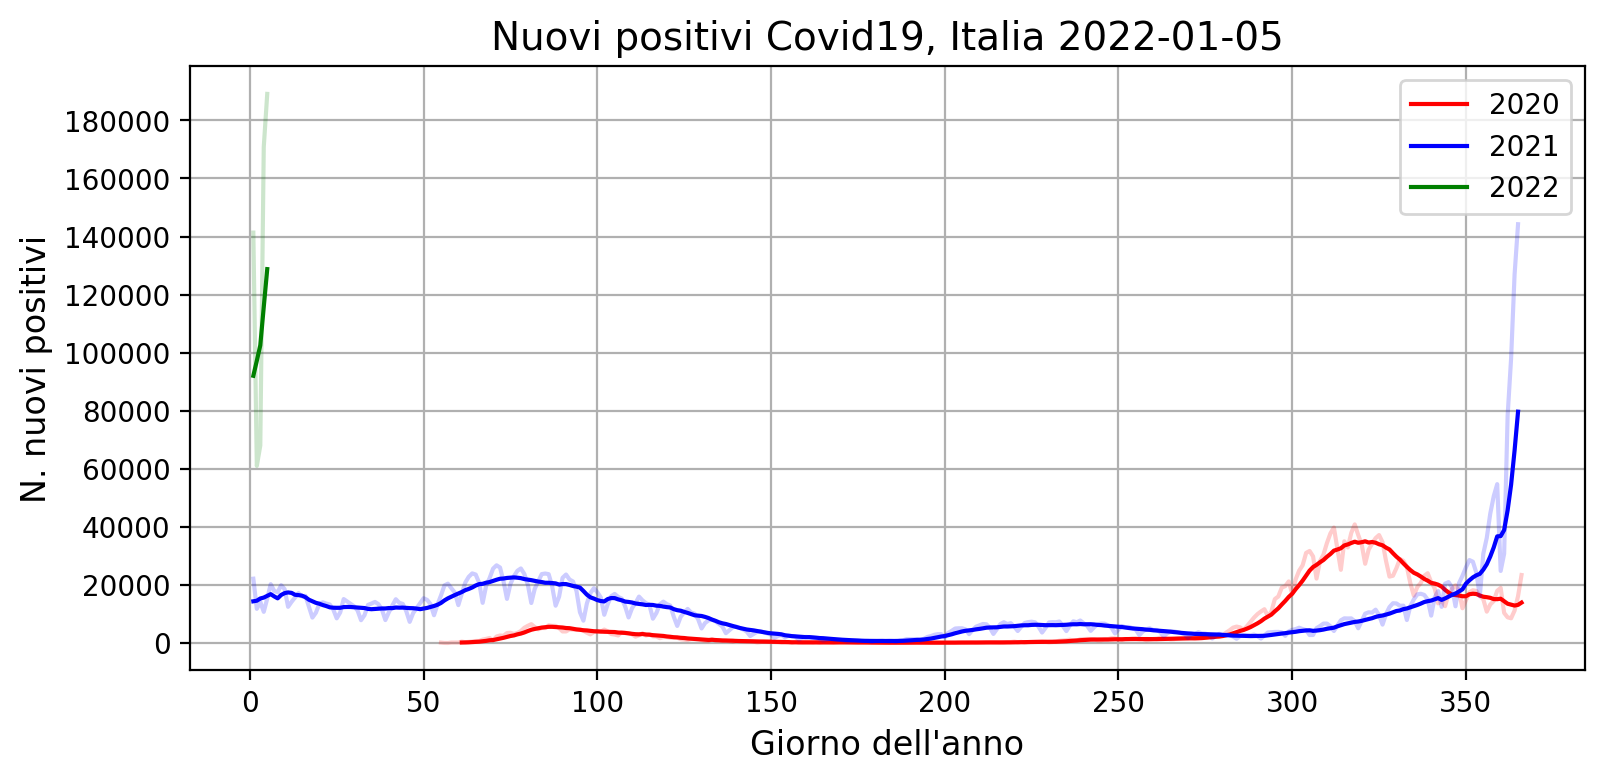

In [90]:
plt.figure(dpi=200,figsize=(9,4))
colors = ["r","b","g"]
i=0
for year in years:
    plt.plot(df_dict[year]["giorno"], df_dict[year]["nuovi_positivi"], alpha=0.2, color=colors[i], label=None)
    plt.plot(df_dict[year]["giorno"], df_dict[year]["nuovi_positivi_media_7"], alpha=1, color=colors[i], label=year)
    i+=1
plt.grid()
plt.xlabel("Giorno dell'anno",fontsize=12)
plt.ylabel("N. nuovi positivi",fontsize=12)
plt.yticks(np.arange(0,200000,20000))
plt.title(f"Nuovi positivi Covid19, Italia {oggi}", fontsize=14)
plt.legend()
plt.savefig(f"./plots/{oggi}/year_comp_nuovi_positivi.png", bbox_inches="tight")

In [ ]:
df[df["nuovi_positivi"]==np.max(df["nuovi_positivi"])][["giorno","nuovi_positivi"]]

### Rapporto ISS

In [ ]:
df_ti = pd.read_csv("./data/rapporti_ISS - TI.csv")
df_decessi = pd.read_csv("./data/rapporti_ISS - Decessi.csv")
df_ricoveri = pd.read_csv("./data/rapporti_ISS - Ricoveri.csv")
df_contagi = pd.read_csv("./data/rapporti_ISS - Contagi.csv")

In [ ]:
df_dict = {
    "diagnosi": df_contagi,
    "ricoveri": df_ricoveri,
    "terapie_intensive": df_ti, 
    "decessi": df_decessi
}

In [ ]:
for d in df_dict.items():
    d[1]["pct_novax"] = 100*d[1]["no_vax_frac"]
    d[1]["data"] = pd.to_datetime(d[1]["data"])
    d[1]["split"] = d[0]

In [ ]:
df_iss = pd.concat(df_dict.values()).reset_index(drop=True)
df_iss["tot"] = df_iss["vax"] + df_iss["no_vax"]
df_iss["data"] = df_iss["data"].astype(str)

In [ ]:
df_iss["data"]

In [ ]:
from benfordslaw import benfordslaw
bl = benfordslaw(alpha=0.05, pos=1)

cat_names = ["no_vax", "1_dose","2_dosi_lt_cut", "2_dosi_gt_cut", "booster"]

for cat in cat_names: 
    if cat != "2_dosi_gt_cut":
        continue
    print(cat)
    X = []
    for d in df_dict.values():
        v = [int(d) for d in d[cat].values]
        X += v
    print(X)
    results = bl.fit(np.array(X))

In [ ]:
fig, ax = bl.plot(title='Dati ISS non vaccinati',fontsize=14)
ax.tick_params(axis='y', labelsize=40)

In [ ]:
dates = []
for d in df_dict.values():
    dates += d["data"].tolist()
dates = sorted(list(set(dates)))
dates_str = [d.strftime("%Y-%m-%d") for d in dates]


In [ ]:
fig, ax = plt.subplots(figsize=(10,5),dpi=100)
for d in df_dict.items():
    df = d[1]
    key = d[0]
    plt.plot(df.data, df.pct_novax, label=key, linewidth=1.8)
plt.xticks(dates, dates_str,
           fontsize=12,
            rotation=50, 
            rotation_mode="anchor", 
            verticalalignment = "top",
            horizontalalignment = "right"
          )
plt.grid()
plt.legend()
plt.title("Incidenza non vaccinati sul totale (ultimi 30 giorni)", fontsize=18)
plt.ylabel("[%]",fontsize=14)
plt.yticks(fontsize=12)
plt.savefig(f"./plots/bollettino_iss_{dates_str[-1]}.png", bbox_inches="tight")

In [ ]:
df["ti_last_30"] = df.sort_values("data")["ingressi_terapia_intensiva"].rolling(30).sum()

In [ ]:
df_daily = df[["giorno","ingressi_terapia_intensiva","ti_last_30"]]
df_daily["data"] = df_daily["giorno"].astype(str)

In [ ]:
df_daily[["data","ti_last_30"]]

In [ ]:
df_iss = df_iss.merge(df_daily, on=["data"], how="inner")

In [ ]:
df_iss[df_iss.split=="terapie_intensive"].sort_values(by="data", ascending=False)[["data","tot","ti_last_30"]].reset_index(drop=True)